## Exploring SWRs in the IBL dataset

This notebook will provide tutorials and explanations on how to relate the output from the detector scripts to task variables in the IBL task.  This tutorial is for students who may be familiar with statistics but do not want to bother with redesigning signal filters or dealing with the signal processing required to identify ripple events.  We will start by visualizing single ripples and comparing those marked as true ripples versus those which are likely motion artifacts.  The detectors are designed to be overly permissive in their definition of events as different users may have different definitions of what passes as a ripple, in particular the peak power may be altered to ensure different false positive and false negative rates.  For instance Nitzan et al., (2022) included events with a peak power of > 3 SD while De Filippo et al., (2023) required peaks of > 5 SD.  You may want to adjust the false positive or false negative rate depending on your use case.  


While the ABI had six neuropixels probes per mouse the IBL typically has two.  Often a recording only has one probe in CA1, if there was one at all.  This means many mice are not usable.  Furthermore the Allen Brian Institute Visual Behaviour dataset typically has more detected events per recording.  Nevertheless the tasks used in the IBL are interesting for their own sake and worth investigating.


Below we can see the experiment IDs from which the data was taken, each ID corresponds to a particular mouse.  In our case each mouse only has one recording session.  I have assigned the mice a number for plotting as well.  You can use the experiment IDs to call data from the ONE-api.  I have shown how to do that here but they also have their own set of tutorials which are more comprehensive for dealing with that data.  I would also recomend reading the tutorials at the github for the ripple detector at edeno/ripple-detection, which was the library used for ripple detection in my detector script.  I encourage a reader to read those as well to get an idea of what they can do with that data.  This tutorial will show how to integrate the IBL data with the SWRs we have detected.  If you want to apply the detectors to your own neuroscience data make sure to load the .imec file as a numpy array.  Ensure the clocks are aligned between the probes and the rest of the data.  I have decided to use mouse 4 for most of these examples as it had the second highest number of SWRs, many in reward times and even showed a correlation in the decision making period.  
  

| Session ID                            | Mouse Number |
| ------------------------------------- | ----- |
| 111c1762-7908-47e0-9f40-2f2ee55b6505  | 1     |
| 83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4  | 2     |
| 09b2c4d1-058d-4c84-9fd4-97530f85baf6  | 3     |
| 1a507308-c63a-4e02-8f32-3239a07dc578  | 4     |
| 8a3a0197-b40a-449f-be55-c00b23253bbf  | 5     |
| 0c828385-6dd6-4842-a702-c5075f5f5e81  | 6     |
| 5339812f-8b91-40ba-9d8f-a559563cc46b  | 7     |
| 931a70ae-90ee-448e-bedb-9d41f3eda647  | 8     |

We will load the libraries used in this tutorial as well.  It should be run in the conda environment I created for working with the ONE-api as we need to call that data for later analyses.

In [1]:
# libraries
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ripple_detection
from scipy.signal import hilbert
from scipy.stats import zscore

IBL Brian viewer: https://github.com/int-brain-lab/iblviewer/blob/main/README.md

In [2]:
import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.utils import resample
import statsmodels.formula.api as smf
import os
import subprocess 
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import io, signal, stats
from scipy.signal import lfilter
#from fitter import Fitter, get_common_distributions, get_distributions
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
import matplotlib.pyplot as plt
# for ripple detection
import ripple_detection
from ripple_detection import filter_ripple_band
import ripple_detection.simulate as ripsim # for making our time vectors
from tqdm import tqdm
from iblatlas.atlas import AllenAtlas
from iblatlas.regions import BrainRegions
from one.api import ONE
import spikeglx
from brainbox.io.one import load_channel_locations
from brainbox.io.spikeglx import Streamer
from neurodsp.voltage import destripe_lfp
import pandas as pd
import os
import glob

# performance metrics
from scipy.stats import chi2
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import patsy
from sklearn.model_selection import StratifiedKFold

#THIS CODE WORKS THIS CODE LOOPS THROUGH THE SESSIONS AND DOWNLOADS THE DATA, WE NEED TO ADD THE RIPPLE DETECTION CODE TO REMOVE THE DATA AFTER 
from neurodsp.voltage import destripe_lfp
from ibllib.plots import Density
import time # for debugging
import traceback
import logging
import statsmodels 

/home/acampbell/miniconda3/envs/ONE_ibl_env/lib/python3.10/site-packages/ibllib/io/raw_data_loaders.py:19: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version


You may need to change this to the filepaths which you set as the output of the detectors.

In [3]:
path_to_ripples = '/space/scratch/IBL_swr_data/testing_dir'
session_id = 'dd4da095-4a99-4bf3-9727-f735077dba66'
swr_folderpath = os.path.join(path_to_ripples, f'swrs_session_{session_id}')

Let's print the files in the output folder to have a look at what is in the output of the detector.  There are two folders one being the events detected on the probe as well as the "filtered_swrs" folder.  This folder contains the combined events from each session which have been created by combining the events from each probe.  This is more important in the ABI data where there are more probes.

In [6]:
# Get a list of all files in the folder
filenames = os.listdir(path_to_ripples)

# Print each filename
for filename in filenames:
    print(filename)

swrs_session_dd4da095-4a99-4bf3-9727-f735077dba66
eventspersession_df.csv
swrs_session_09b2c4d1-058d-4c84-9fd4-97530f85baf6


In [9]:
# Get a list of all files in the folder
filenames = os.listdir(swr_folderpath)

# Print each filename
print("In '" + swr_folderpath + "/' we have the following files:")
for filename in filenames:
    print(filename)

In '/space/scratch/IBL_swr_data/testing_dir/swrs_session_dd4da095-4a99-4bf3-9727-f735077dba66/' we have the following files:
probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_gamma_band_events.csv
probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_karlsson_detector_events.csv
probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_239_movement_artifacts.csv
session_dd4da095-4a99-4bf3-9727-f735077dba66_putative_global_swrs_no_movement_no_gamma.csv
probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_74_movement_artifacts.csv


Notice that the files are names systematically so that you can identify exactly where the data originated from.  The probes in the IBL all have unique id's which are applied here.  In the ABI the channels also have unique Ids but in the IBL this is not the case instead the row number and alyx file object are used.  So in channels.rawInd that value is used after channel.  Using regex we can pull out specific files.  

We will go through how each of these files is generated below.

In [13]:
filename = 'probe_8f2e16c4-893b-4f8f-bfb2-94fa452710ec_channel_channelsrawInd_217_karlsson_detector_events.csv'
probe0events_df = pd.read_csv(os.path.join(swr_folderpath, filename), compression='gzip')
probe0events_df.head(10)

,event_number,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,Peak_time,Overlaps_with_gamma,Overlaps_with_movement
0,1,1.410667,1.510667,0.100000,3.625943,2.199558,12.195477,0.015032,1.461334,False,False
1,3,5.671335,5.725335,0.054000,1.731126,1.099215,4.930591,0.005324,5.707335,False,False
2,4,5.752668,5.859335,0.106667,1.653088,0.832050,5.818003,0.011028,5.816668,False,False
3,5,7.950002,8.072003,0.122000,1.114003,0.780271,4.483550,0.000639,7.994669,False,False
4,8,12.107337,12.206670,0.099333,1.332537,1.009184,4.701645,0.064071,12.152670,False,False
5,9,18.436006,18.519339,0.083333,1.816431,1.567564,4.504517,0.019108,18.486006,False,False
6,10,24.904008,24.968008,0.064000,1.071760,0.538622,2.906464,0.007126,24.943341,False,False
7,12,52.014683,52.088016,0.073333,1.176454,0.872736,3.133274,0.015170,52.056683,False,False
8,14,81.370692,81.472692,0.102000,1.254356,0.826088,4.072290,0.004225,81.433359,False,False
9,16,98.258031,98.326697,0.068667,3.574068,3.311438,8.297568,0.024516,98.287364,False,False


In [17]:
probe0events_df.shape

(388, 11)

In [16]:
probe0events_df.Overlaps_with_movement.value_counts()

False    388
Name: Overlaps_with_movement, dtype: int64

In [14]:
probe0events_df.Overlaps_with_gamma.value_counts()

False    388
Name: Overlaps_with_gamma, dtype: int64

I favored an approach that saved an overly permissive set of events which can easily be filtered downstream from processing the LFP files with simple conditional statements rather than forcing a user to rerun the collection script.  Though the envelope calculations cannot be changed here and will require rerunning the detctor if changing the > 2 SD definition is to be altered.  This is because there is generally a disagreement across publications as to what threshold in peak amplitude should be used and methods of artifact detection.  Here we will use the threshold of 3 SD peak frequency.  I have decided to start with the output before describing the collection script to give context for what the script is doing.  For our purposes all we care about are the max_zscore and whether the detected event overlaps with a movement artifact detected in a non-hippocampal control channel.

In [10]:
controlchannel_1_filename = 'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_254_movement_artifacts.csv'
movementevents_1_df = pd.read_csv(os.path.join(swr_folderpath, controlchannel_1_filename))
controlchannel_2_filename = 'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_42_movement_artifacts.csv'
movementevents_2_df = pd.read_csv(os.path.join(swr_folderpath, controlchannel_2_filename))

To save time loading the LFP directly from the ONE-api and preprocessing it, which can take a lot of time. I have instead opted to just save the processed and interpolated LFP data here.  The LFP from the IBL is given as a time series sampled at 2500 Hz, which I have downsampled to 1500 Hz to use in conjunction with the Frank Lab ripple filters, and my own filters which I built for the same sampling rate to prevent conflict with the Frank Lab filters.  It should be noted your own filters could be designed as well using the MNE package if you felt a want or need to do so. 

In [11]:
# all these have been save at the 1500 hz sampling rate
ca1_channel_lfp = np.load(os.path.join(swr_folderpath,'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_383_lfp_ca1_peakripplepower.npz'))
ca1_channel_lfp = ca1_channel_lfp['lfp_ca1']
movementevents_1_lfp = np.load(os.path.join(swr_folderpath,'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_254_lfp_control_channel.npz'))
movementevents_1_lfp = movementevents_1_lfp['lfp_control_channel']
movementevents_2_lfp = np.load(os.path.join(swr_folderpath,'probe_834fca72-0b69-44e4-b77e-95a61290b50d_channel_channelsrawInd_42_lfp_control_channel.npz'))
movementevents_2_lfp = movementevents_2_lfp['lfp_control_channel']

# reshape them because numpy doesn't like 1d numpy arrays with shape (n,1) it wants (n,) trust me this step will save you pain later
ca1_channel_lfp = ca1_channel_lfp.reshape(-1)
print(ca1_channel_lfp.shape)
movementevents_1_lfp = movementevents_1_lfp.reshape(-1)
print(movementevents_1_lfp.shape)
movementevents_2_lfp = movementevents_2_lfp.reshape(-1)
print(movementevents_2_lfp.shape)

(8024792,)
(8024792,)
(8024792,)


Here we create the time array to be able to pull out times of interest for plotting.

In [12]:
# making a time series for the lfp
# `n` is the number of samples in your signal
n = ca1_channel_lfp.shape[0]

# Create a time vector. Since your signal is sampled at 1500 Hz, the total time for n samples is n / 1500.
time_arr = np.linspace(0, n / 1500, n)

In [13]:
time_arr.shape

(8024792,)

### Visualizing LFP (raw, band pass, signal power) and Ripples

We can start by looking at the LFP traces across the whole recording.  Though at this time scale and using raw LFP it will be uninformative.  The events we care about occur over fractions of a second and are defined by changes in instantaneous signal power.  Even lowest frequency signal of interest in waking behaviour, theta, has an 8 Hz cycle.  For the most part we want to look at events on the scale of a single second.  The code below however is going to serve as the basis for later plotting.  It is worth noting that making a nice looking figure will take some experimentation.  You will need to see what the ranges of your data are so you can set reasonable limits on the plotting.  The axis should be within fixed ranges to make comparisons between events by visual inspection easier.  

In [14]:
# we should create the ripple band signal as well
ripple_band_ca1 = ripple_detection.filter_ripple_band(ca1_channel_lfp[:,None])

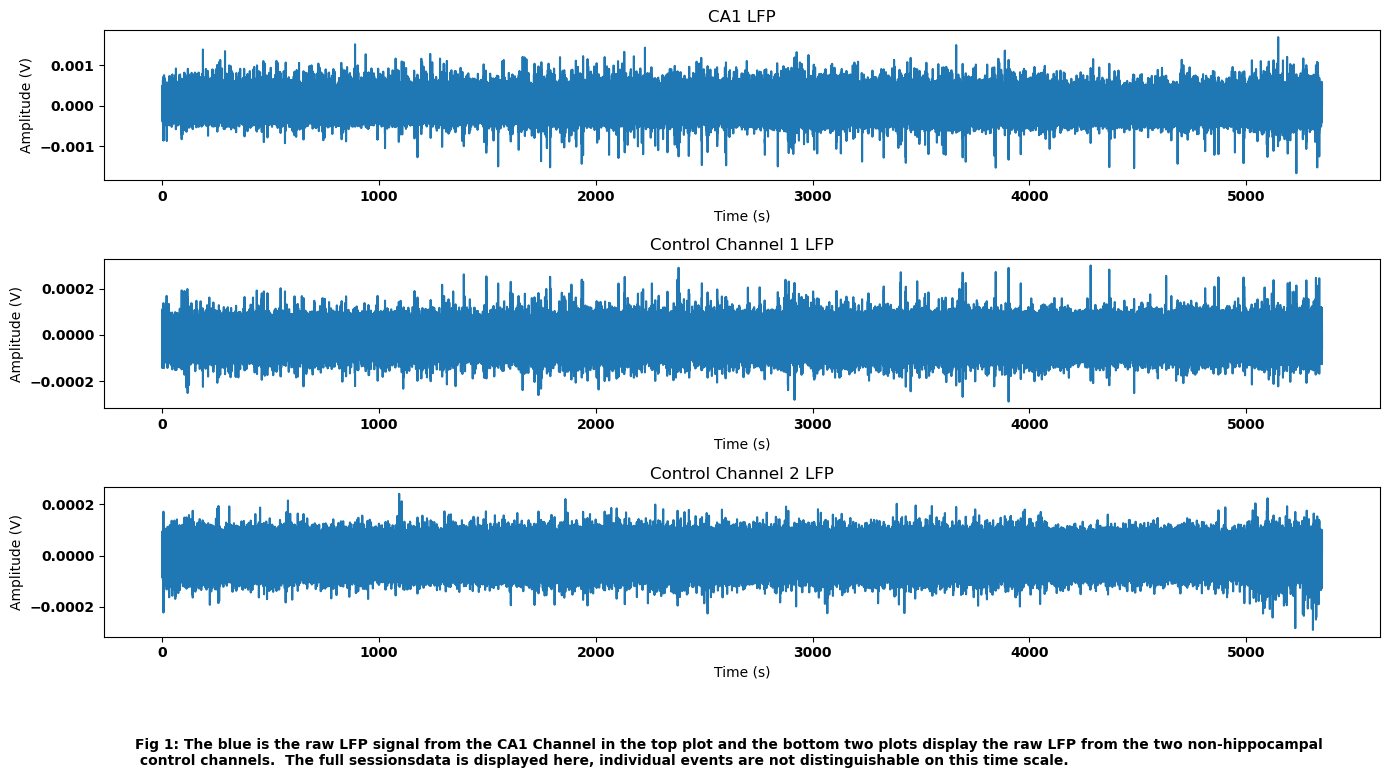

In [44]:
import matplotlib.pyplot as plt

# Assuming movementevents_1_lfp, movementevents_2_lfp, movementevents_3_lfp are your LFP data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(time_arr, ca1_channel_lfp)
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.subplot(3, 1, 2)
plt.plot(time_arr, movementevents_1_lfp)
plt.title('Control Channel 1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.subplot(3, 1, 3)
plt.plot(time_arr, movementevents_2_lfp)
plt.title('Control Channel 2 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 1: The blue is the raw LFP signal from the CA1 Channel in the top plot and the bottom two plots display the raw LFP from the two non-hippocampal \n control channels.  The full sessionsdata is displayed here, individual events are not distinguishable on this time scale.  ", ha="left")


plt.tight_layout()
plt.show()

Looking at the LFP over the entire time series is confusing.  But we are going to be focusing in on smaller timelines to see up close what our detector has done, what constitutes an artifact and what the transformations we have done to our data are doing. 

In [16]:
probe0_filtered_events_df = probe0_events_df[probe0_events_df.max_zscore>=3]

This dataframe is the uncleaned events table, some of these may be ripple some may not depending on the threshold you want to have for your data.  These publications have certain criteria Nitzan et al., and buszai one ofr instance.

In [17]:
probe0_filtered_events_df.head(20)

,event_number,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed,Peak_Amp_RipBandPower,Peak_Amp_RipBandPower_zscore,Peak_time,Overlaps_with_gamma,Overlaps_with_movement
0,1,5.198665,5.368665,0.170000,8.383429,7.803107,21.397163,0.093998,0.0,0.0,0.0,0.0,0.0,0.0,5.558120e-08,32.385133,5.228665,False,False
1,2,7.559333,7.631333,0.072000,2.069463,1.377305,4.976076,0.006764,0.0,0.0,0.0,0.0,0.0,0.0,3.785743e-09,2.061526,7.575999,False,False
2,3,8.119333,8.261333,0.142000,3.969249,1.590572,13.303769,0.029314,0.0,0.0,0.0,0.0,0.0,0.0,2.050813e-08,11.851632,8.212000,False,False
3,4,21.001336,21.109336,0.108000,5.270422,0.887353,20.576165,0.015374,0.0,0.0,0.0,0.0,0.0,0.0,5.371702e-08,31.293751,21.061336,False,False
4,5,21.194003,21.242003,0.048000,3.827845,3.016206,9.409178,0.043060,0.0,0.0,0.0,0.0,0.0,0.0,1.394534e-08,8.009453,21.228003,False,False
6,7,43.245341,43.333341,0.088000,2.126785,1.077333,6.440968,0.009205,0.0,0.0,0.0,0.0,0.0,0.0,5.898865e-09,3.298651,43.283341,True,False
7,8,43.342675,43.460675,0.118000,1.934399,1.501250,5.491583,0.038187,0.0,0.0,0.0,0.0,0.0,0.0,5.359419e-09,2.982833,43.371341,True,False
8,9,45.445342,45.538675,0.093333,2.987916,3.216691,5.418923,0.023603,0.0,0.0,0.0,0.0,0.0,0.0,5.769973e-09,3.223192,45.473342,False,False
9,10,59.286678,59.358678,0.072000,1.622729,1.522974,3.462827,0.014949,0.0,0.0,0.0,0.0,0.0,0.0,2.502840e-09,1.310451,59.332678,False,False
10,11,63.004679,63.062013,0.057333,2.392827,2.100778,5.289160,0.029897,0.0,0.0,0.0,0.0,0.0,0.0,4.851882e-09,2.685696,63.046013,True,False


Select an event by changing the value of rip_id variable in the code below and plot a few different events.  The plot will be centered around the peak_time of the ripple, which is when the power in the ripple frequency band peaks.  The offset variable sets the time window around the ripple, here is half a second long so we are plotting a total of one second worth of the LFP data.  I have three plots here, one for each of the channels.  THe CA1 channel as well as the two control channels.  In blue the raw unfiltered LFP trace for each is given.  Ine the CA1 plot I have also plotted the ripple band signal (150-250 Hz) in faded black, the red dotted lines indicate what the envelope is here.  As mentioned previously the envelope is the point at which the instantaneous power of the ripple-band signal exceeds 2 SD greater than the mean.


You will note in these events the CA1 channel is displaying the characteristic fast oscillations of the ripples.  There is often also a sharp dip, from the sharp wave component.

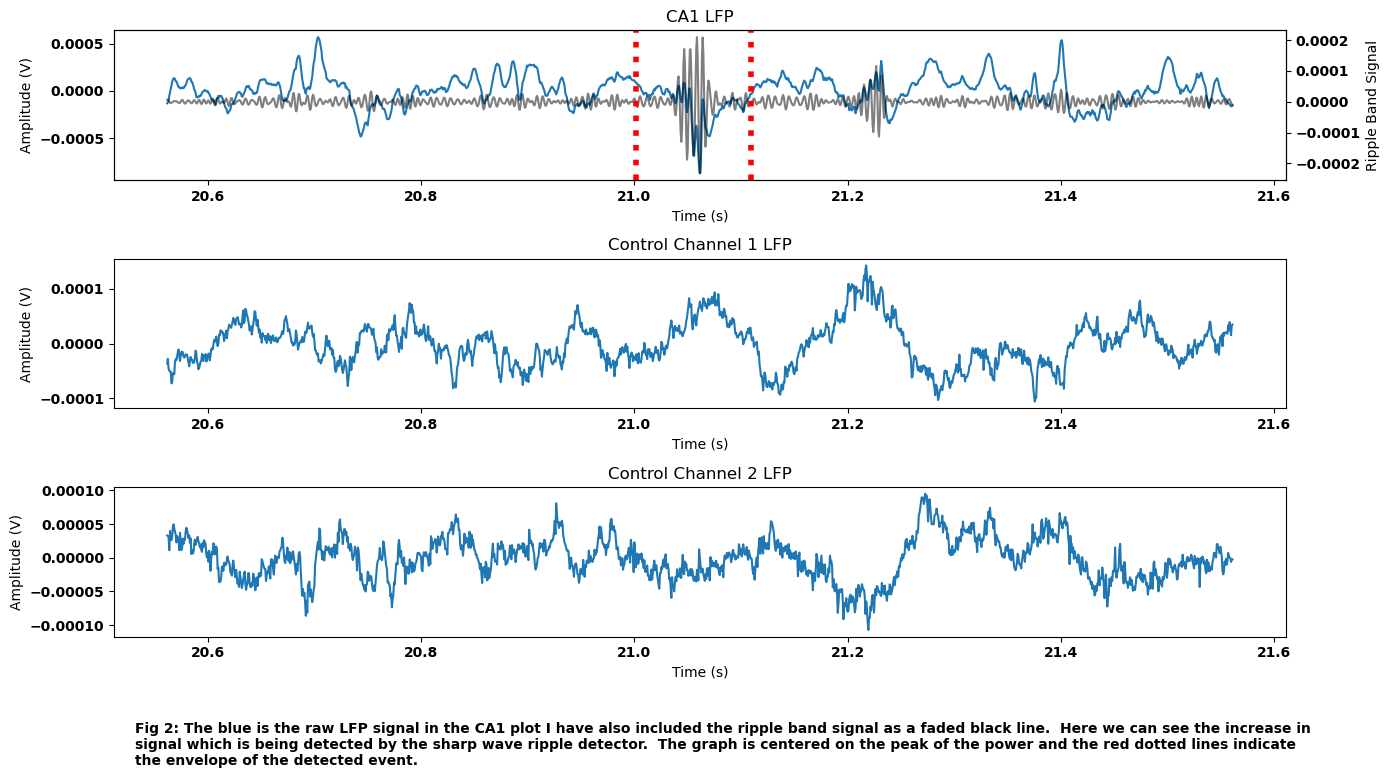

In [42]:
## CHANGE THIS VARIABLE TO THE RIPPLE ID YOU WANT TO PLOT, EXPLORE THE DATA A BIT TO FIND A GOOD RIPPLE
rip_id = 4

peaktime = probe0_filtered_events_df.Peak_time[probe0_filtered_events_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_channel_lfp_slice = ca1_channel_lfp[mask]
#ca1_ripple_power_slice = zscored_ripple_power_ca1[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]
movementevents_1_lfp_slice = movementevents_1_lfp[mask]
movementevents_2_lfp_slice = movementevents_2_lfp[mask]

# Assuming movementevents_1_lfp, movementevents_2_lfp, movementevents_3_lfp are your LFP data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_channel_lfp_slice)
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis


# Add red dotted lines
rip_start_time = probe0_filtered_events_df.start_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = probe0_filtered_events_df.end_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, movementevents_1_lfp_slice)
plt.title('Control Channel 1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, movementevents_2_lfp_slice)
plt.title('Control Channel 2 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 2: The blue is the raw LFP signal in the CA1 plot I have also included the ripple band signal as a faded black line.  Here we can see the increase in \nsignal which is being detected by the sharp wave ripple detector.  The graph is centered on the peak of the power and the red dotted lines indicate \nthe envelope of the detected event.", ha="left")

plt.tight_layout()
plt.show()

Now we will filter the dataframe of event metadata for events that do overlap with movement.  These events should not be included in the analysis as they are likely caused by the probe jiggling which results in short high frequency events across multiple channels.  These have been detected by randomly chosing channels outside hippocampus and running the detector on these.  I have opted for an overly strict definition where if events in the non-hippocampal channel overlaps.

In [19]:
probe0_filtered_events_df[probe0_filtered_events_df.Overlaps_with_movement==True]

,event_number,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed,Peak_Amp_RipBandPower,Peak_Amp_RipBandPower_zscore,Peak_time,Overlaps_with_gamma,Overlaps_with_movement
28,29,123.285361,123.331361,0.046000,2.755935,2.687499,5.557608,0.005326,0.0,0.0,0.0,0.0,0.0,0.0,5.127249e-09,2.846909,123.306694,True,True
30,31,132.400696,132.448029,0.047333,2.047281,2.140836,3.845957,0.028588,0.0,0.0,0.0,0.0,0.0,0.0,3.014526e-09,1.610017,132.436696,False,True
35,36,150.512700,150.603367,0.090667,1.625692,1.692358,3.960643,0.007709,0.0,0.0,0.0,0.0,0.0,0.0,3.254351e-09,1.750423,150.534034,True,True
43,44,187.660043,187.723376,0.063333,2.111668,1.239652,6.349444,0.006188,0.0,0.0,0.0,0.0,0.0,0.0,7.923687e-09,4.484082,187.691376,True,True
47,48,201.113379,201.214713,0.101333,1.888335,1.107448,7.253149,0.015107,0.0,0.0,0.0,0.0,0.0,0.0,8.952489e-09,5.086393,201.174046,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,1513,5263.385266,5263.457266,0.072000,2.032199,1.269727,5.390565,0.032723,0.0,0.0,0.0,0.0,0.0,0.0,5.117952e-09,2.841467,5263.426599,True,True
1506,1528,5279.410603,5279.529270,0.118667,2.629846,2.520448,7.067364,0.006928,0.0,0.0,0.0,0.0,0.0,0.0,1.010432e-08,5.760733,5279.448603,True,True
1515,1537,5311.609277,5311.681277,0.072000,1.593229,0.557076,4.862218,0.010820,0.0,0.0,0.0,0.0,0.0,0.0,5.170577e-09,2.872276,5311.660611,False,True
1518,1540,5321.947280,5322.013280,0.066000,1.269463,0.572553,4.298267,0.002493,0.0,0.0,0.0,0.0,0.0,0.0,4.092871e-09,2.241333,5321.986613,True,True


Here we can see in the same plot the LFP of the CA1 channel as well as in the control channels.  The motion artifacts tend to be shorter than a ripple event.  They also are marked by sudden sharp jumps in 

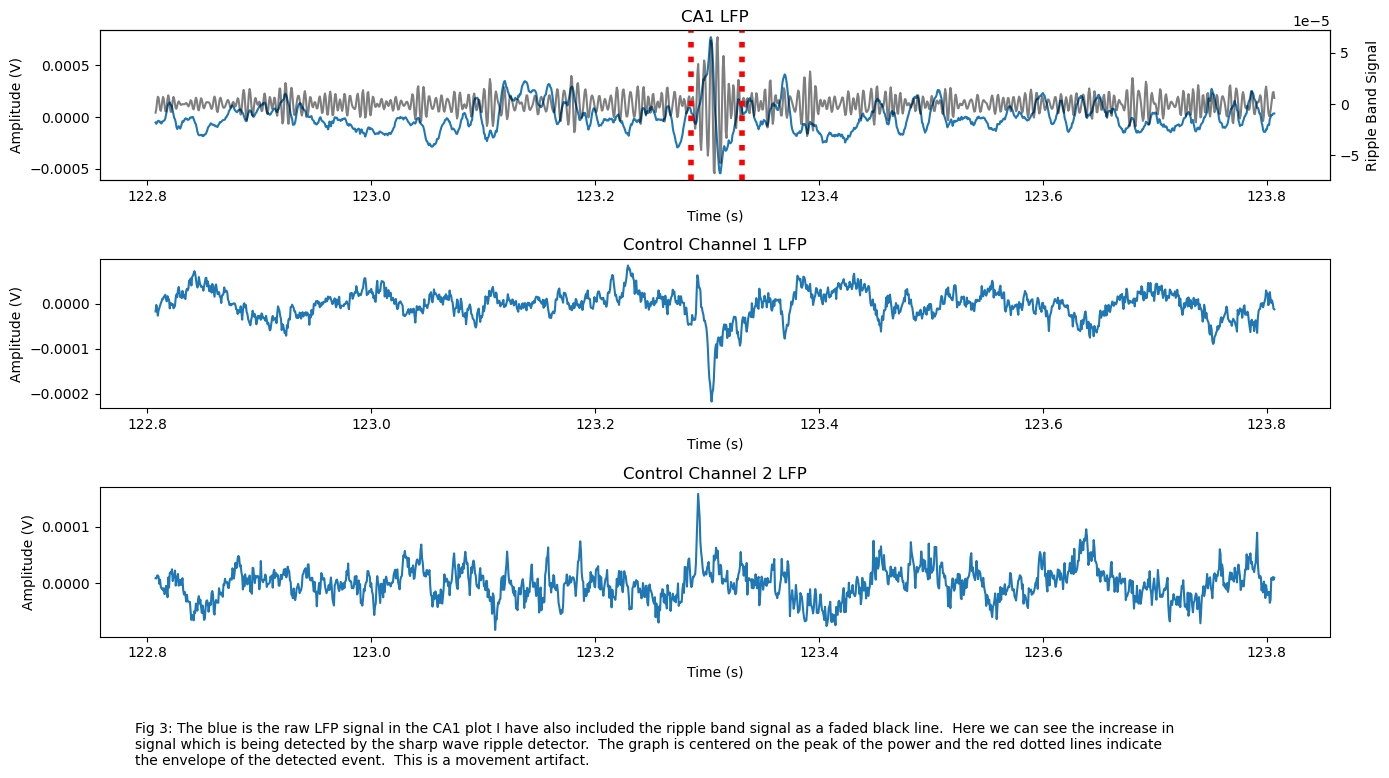

In [20]:
# Change the event number to pick a different ripple
rip_id = 29 # this variable
peaktime = probe0_filtered_events_df.Peak_time[probe0_filtered_events_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_channel_lfp_slice = ca1_channel_lfp[mask]
#ca1_ripple_power_slice = zscored_ripple_power_ca1[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]
movementevents_1_lfp_slice = movementevents_1_lfp[mask]
movementevents_2_lfp_slice = movementevents_2_lfp[mask]

# Assuming movementevents_1_lfp, movementevents_2_lfp, movementevents_3_lfp are your LFP data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_channel_lfp_slice)
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

# Add red dotted lines
rip_start_time = probe0_filtered_events_df.start_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = probe0_filtered_events_df.end_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, movementevents_1_lfp_slice)
plt.title('Control Channel 1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

plt.subplot(3, 1, 3)
plt.plot(time_arr_slice, movementevents_2_lfp_slice)
plt.title('Control Channel 2 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 3: The blue is the raw LFP signal in the CA1 plot I have also included the ripple band signal as a faded black line.  Here we can see the increase in \nsignal which is being detected by the sharp wave ripple detector.  The graph is centered on the peak of the power and the red dotted lines indicate \nthe envelope of the detected event.  This is a movement artifact.", ha="left")


plt.tight_layout()
plt.show()

So while we do see the increase in ripple band signal in the detected event, there are simultaneous sharp jumps in non-hippocampal signal.  This is not biological signal, it is likely a motion artifact and should be excluded.  You can cycle through the events which has a "True" value in Overlaps_with_movement and you will notice these jumps in nearly all of them.  The duration all tends to be shorter than many biological SWRs.

## Gamma Band events

As I am also detecting high frequency events during movement it is important to fast gamma events which may bleed into the ripple band.  These events do not necessarily need to be excluded, but rerunning an analysis with events which concomitantly high fast gamma and showing an effect survives this filter can support the interpretation that it is ripple band events which are correlated and not gamma.  Small changes to your pipeline should not result in the loss of a robust effect, it is good to play with these parameters and check for alternative explanations while doing any analysis.

In [21]:
def zscore_padded_signal(signal, pad_length):
    """
    Z-score a signal, while ignoring the padded region to remove edge effects.
    Parameters
    ----------
    signal : 1D array
        The signal to z-score.
    pad_length : int
        The number of samples to pad the signal with.
    Returns
    -------
    zscored_signal : 1D array
        The z-scored signal.     
    """
    # Remove pad from beginning and end of signal
    signal_no_pad = signal[pad_length:-pad_length]

    # Compute z-score on the remaining signal
    zscored_signal_no_pad = zscore(signal_no_pad)

    # Create an array of NaNs with the same length as the original signal
    zscored_signal = np.full(signal.shape, np.nan)

    # Replace the non-pad part of the zscored_signal with the z-scored signal without pad
    zscored_signal[pad_length:-pad_length] = zscored_signal_no_pad

    return zscored_signal

In [22]:
# make the filtered power bands as well
ripple_band_ca1 = ripple_detection.filter_ripple_band(ca1_channel_lfp[:,None])
zscored_ripple_power_ca1 = zscore_padded_signal(np.abs(hilbert(ripple_band_ca1))**2, pad_length=954)

# load the theta and fast gamam band filters
fastgamma_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/frank2008_gamma_1500hz_bandpass_filter.npz'
fastgamma_filt = np.load(os.path.join(path_to_ripples, fastgamma_path))
fastgamma_filt = fastgamma_filt['arr_0']

# theta filter
theta_path = '/home/acampbell/NeuropixelsLFPOnRamp/PowerBandFilters/swr_detection_script_filters_1500Hz/theta_1500hz_bandpass_filter.npz'
theta_filt = np.load(os.path.join(path_to_ripples, theta_path))
theta_filt = theta_filt['arr_0']

fast_gamma_band_ca1 = np.convolve(ca1_channel_lfp, fastgamma_filt, mode='same')
zscored_gamma_power_ca1 = zscore_padded_signal(np.abs(hilbert(fast_gamma_band_ca1))**2, pad_length=4951)
theta_band_ca1 = np.convolve(ca1_channel_lfp, theta_filt, mode='same')
zscored_theta_power_ca1 = zscore_padded_signal(np.abs(hilbert(theta_band_ca1))**2, pad_length=4951)

Please note that these filters are being convolved which can be intuitively understood as two functions being slid past one another and multiplied at every point.  This means that the filter at the beginning and end of the signal is integrating information from outside the signal itself and points where it doesn't exist.  So we should ignore results from the beginning and end of the signal.

I am going to print my fitlered events dataframe again to pick an event to look at.  I will filter out most columns to make the dataframe easier to read.

In [23]:
probe0_filtered_events_df[['event_number','duration','Peak_time','max_zscore','Overlaps_with_gamma']].head(20)

,event_number,duration,Peak_time,max_zscore,Overlaps_with_gamma
0,1,0.170000,5.228665,21.397163,False
1,2,0.072000,7.575999,4.976076,False
2,3,0.142000,8.212000,13.303769,False
3,4,0.108000,21.061336,20.576165,False
4,5,0.048000,21.228003,9.409178,False
6,7,0.088000,43.283341,6.440968,True
7,8,0.118000,43.371341,5.491583,True
8,9,0.093333,45.473342,5.418923,False
9,10,0.072000,59.332678,3.462827,False
10,11,0.057333,63.046013,5.289160,True


It appears events 7 and 8 may infact be gamma band activity bleeding into the ripple band.  Lets plot the activity of a good ripple first and look at the gamma activity.

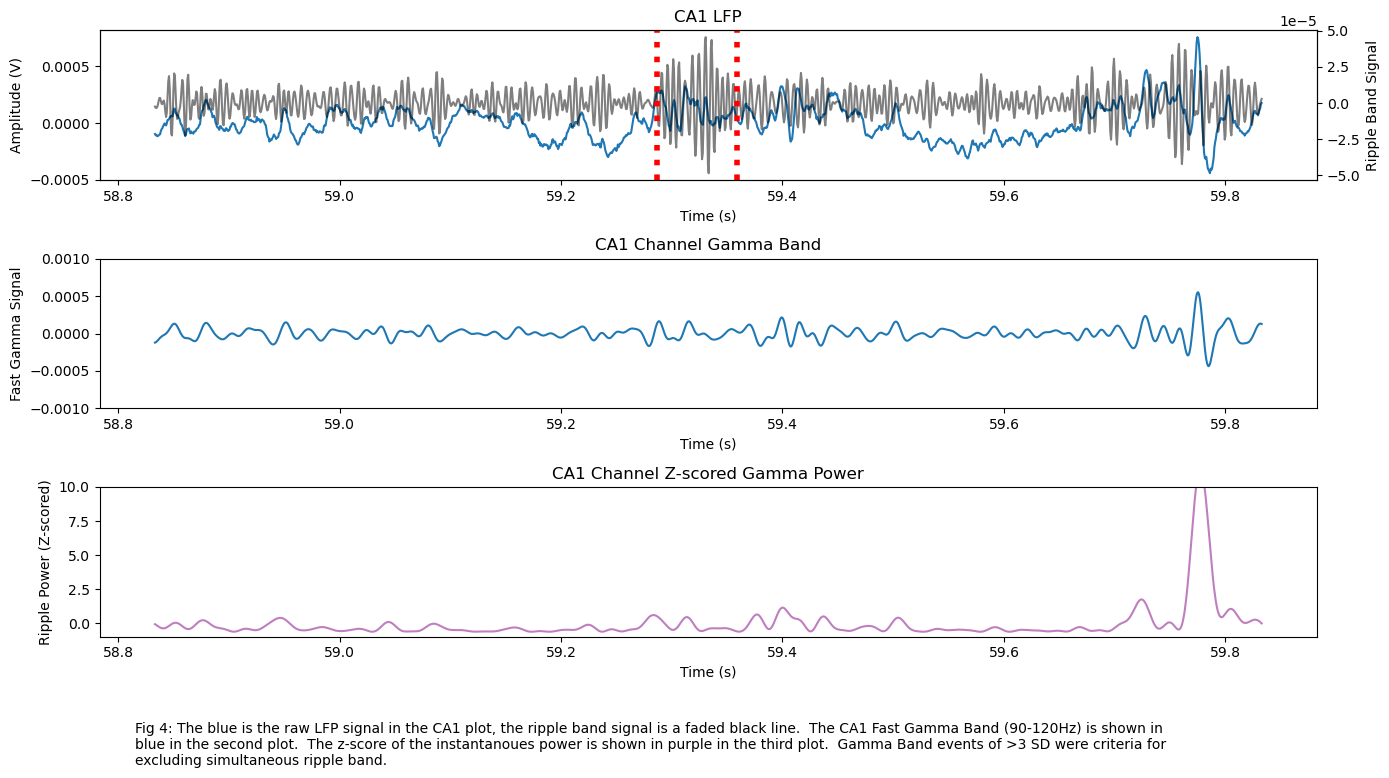

In [24]:
# Change the event number to pick a different ripple
rip_id = 10 
peaktime = probe0_filtered_events_df.Peak_time[probe0_filtered_events_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_channel_lfp_slice = ca1_channel_lfp[mask]
#ca1_ripple_power_slice = zscored_ripple_power_ca1[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]
fast_gamma_band_ca1_slice = fast_gamma_band_ca1[mask]
theta_band_ca1_slice = theta_band_ca1[mask]

# Assuming movementevents_1_lfp, movementevents_2_lfp, movementevents_3_lfp are your LFP data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_channel_lfp_slice)
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 LFP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

# Add red dotted lines
rip_start_time = probe0_filtered_events_df.start_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = probe0_filtered_events_df.end_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, fast_gamma_band_ca1_slice)
plt.ylim(-0.001, 0.001)
plt.title('CA1 Channel Gamma Band')
plt.xlabel('Time (s)')
plt.ylabel('Fast Gamma Signal')

plt.subplot(3, 1, 3)

plt.plot(time_arr_slice, zscored_gamma_power_ca1[mask], color='purple', alpha=0.5) 
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.ylim(-1, 10)
plt.title('CA1 Channel Z-scored Gamma Power') 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Power (Z-scored)')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 4: The blue is the raw LFP signal in the CA1 plot, the ripple band signal is a faded black line.  The CA1 Fast Gamma Band (90-120Hz) is shown in \nblue in the second plot.  The z-score of the instantanoues power is shown in purple in the third plot.  Gamma Band events of >3 SD were criteria for \nexcluding simultaneous ripple band.", ha="left")


plt.tight_layout()
plt.show()

As can be seen above there is very low gamma power, while we are getting a strong signal in higher frequency ranges.  The blue line in the second graph here is the gamma band signal and in the plot bellow that is the z-scored instantaneous power computed as the squared absolute Hilbert transform of the gamma band.  By contrast the event below is an event where Fast Gamma Power may have bled into the ripple band signal, leading to an erroneous ripple detection.

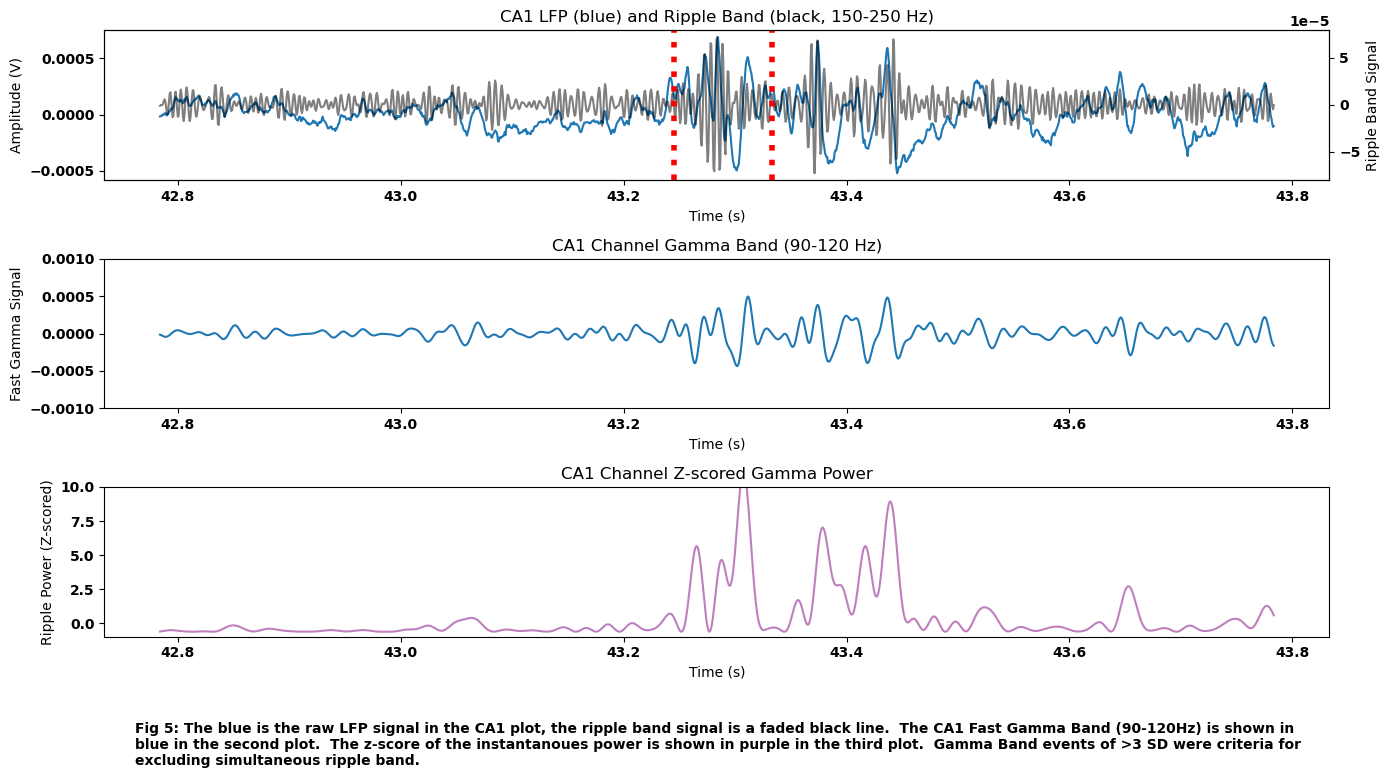

In [151]:
# Change the event number to pick a different ripple
rip_id = 7
peaktime = probe0_filtered_events_df.Peak_time[probe0_filtered_events_df.event_number == rip_id].values[0]
offset = 0.5
mask = (time_arr > (peaktime-offset)) & (time_arr < (peaktime+offset))
time_arr_slice = time_arr[mask]
ca1_channel_lfp_slice = ca1_channel_lfp[mask]
#ca1_ripple_power_slice = zscored_ripple_power_ca1[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]
fast_gamma_band_ca1_slice = fast_gamma_band_ca1[mask]
theta_band_ca1_slice = theta_band_ca1[mask]

# Assuming movementevents_1_lfp, movementevents_2_lfp, movementevents_3_lfp are your LFP data
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)

plt.plot(time_arr_slice, ca1_channel_lfp_slice)
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 LFP (blue) and Ripple Band (black, 150-250 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')

# plot the ripple band first so the LFP goes on top
ax2 = plt.twinx()  # Create a second y-axis
ax2.plot(time_arr_slice, ca1_ripple_power_slice, color='black', alpha=0.5)  # Plot on the second y-axis with black color
ax2.set_ylabel('Ripple Band Signal')  # Set label for the second y-axis

# Add red dotted lines
rip_start_time = probe0_filtered_events_df.start_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_start_time, color='r', linestyle=':', linewidth=4)
rip_end_time = probe0_filtered_events_df.end_time[probe0_filtered_events_df.event_number == rip_id].values[0]
plt.axvline(x=rip_end_time, color='r', linestyle=':', linewidth=4)

plt.subplot(3, 1, 2)
plt.plot(time_arr_slice, fast_gamma_band_ca1_slice)
plt.ylim(-0.001, 0.001) 
plt.title('CA1 Channel Gamma Band (90-120 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Fast Gamma Signal')

plt.subplot(3, 1, 3)

plt.plot(time_arr_slice, zscored_gamma_power_ca1[mask], color='purple', alpha=0.5) 
#plt.plot(time_arr_slice, ca1_ripple_power_slice)  # Add this line
plt.title('CA1 Channel Z-scored Gamma Power')
plt.ylim(-1, 10) 
plt.xlabel('Time (s)')
plt.ylabel('Ripple Power (Z-scored)')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 5: The blue is the raw LFP signal in the CA1 plot, the ripple band signal is a faded black line.  The CA1 Fast Gamma Band (90-120Hz) is shown in \nblue in the second plot.  The z-score of the instantanoues power is shown in purple in the third plot.  Gamma Band events of >3 SD were criteria for \nexcluding simultaneous ripple band.", ha="left")


plt.tight_layout()
plt.show()

We can see these brief bursts of Gamma power occuring which may have bled into our detectors range.  We can keep these events for analysis but models and correlations should be recomputed without them to see if they survive removal of these events.  This was done in Cheng & Frank (2008) when analysing HFE's.

## Exploratory Data Analysis

There are several features of SWRs that may be of interest to examine as well.  While regression models may prove useful for testing more complex relationships we can begin to examine the data for simple and interesting correlations to behavioural features SWRs are related to in previous literature.  I will also show how to load data across multiple sessions to these results.  This will also show how to analyze the data in a systematic way across many recordings.

In [26]:
# functions
def process_dict(d):
    data_dict = {}

    for key, value in d.items():
        if isinstance(value, np.ndarray) and value.ndim == 2 and value.shape[1] == 2:
            data_dict[key + '_start'] = value[:, 0]
            data_dict[key + '_end'] = value[:, 1]
        elif isinstance(value, list) and len(value) == 2 and all(isinstance(i, np.ndarray) for i in value):
            data_dict[key + '_start'] = value[0]
            data_dict[key + '_end'] = value[1]
        else:
            data_dict[key] = value

    df = pd.DataFrame(data_dict)

    return df

def create_contrast_df(trials_df, n_back=5, priors_start=6):
    # Create a new DataFrame with the same index as trials_df
    contrast_df = pd.DataFrame(index=trials_df.index)

    # Create a column for the current trial
    contrast_df['current_trial'] = np.where(trials_df['contrastLeft'].isna(), 1, 0)

    # Create the 'contrast_diff' column
    contrast_df['contrast_diff'] = trials_df['contrastLeft'].fillna(0) - trials_df['contrastRight'].fillna(0)

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale the 'contrast_diff' column
    contrast_df['contrast_diff_minmax'] = scaler.fit_transform(contrast_df[['contrast_diff']])

    # Create columns for the five previous trials
    for i in range(1, n_back + 1):
        contrast_df[f'n_trial_back_{i}'] = contrast_df['current_trial'].shift(i)

    # Compute the prior across trials
    contrast_df['prior'] = contrast_df['current_trial'].expanding().mean().shift(priors_start+1).fillna(0)

    # Compute the whole session average
    contrast_df['session_avg'] = contrast_df['current_trial'].expanding().mean()

    # Compute the session average from 3-20 trials back
    contrast_df['session_avg_3_20'] = contrast_df['current_trial'].rolling(window=20, min_periods=3).mean().shift()

    # Include the 'choiceLeft' column from trials_df
    contrast_df['choiceLeft'] = np.where(trials_df['choice'] == 1, 1, 0)
    
    return contrast_df

def logreg_crossval(data, formula, fold_number):
    """
    Perform cross-validated logistic regression.
    
    Parameters
    ----------
    data : DataFrame
        The DataFrame containing both the feature matrix and the target vector.
    formula : str
        A Patsy formula specifying the model.
    fold_number : int
        The number of folds for cross-validation.
        
    Returns
    -------
    dict
        A dictionary with three keys: "results", "splits", and "model_fits". "results" is a DataFrame of the results of the 
        cross-validated logistic regression. Summary statistics for each fold are included. "splits" is the 
        KFold object used for the cross-validation. "model_fits" is a DataFrame containing the fitted parameters for each model
        in each split.
    """
    
    # Create the design matrices using the Patsy formula
    y, X = patsy.dmatrices(formula, data, return_type='dataframe')
    
    # Initialize the KFold object
    kf = StratifiedKFold(n_splits=fold_number)
    
    # Initialize lists to store the results and model_fits
    results_list = []
    model_fits_list = []

    # Perform cross validation
    for i, (train_index, test_index) in enumerate(kf.split(X, y[y.columns[0]])):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the logistic regression model
        model = sm.Logit(y_train, X_train).fit(disp=0)

        # Get the model summary as a DataFrame
        summary_df = model.summary2().tables[1]

        # Add a column for the fold number
        summary_df['fold'] = i + 1

        # Append the summary DataFrame to the results list
        results_list.append(summary_df)

        # Calculate performance metrics
        y_pred = model.predict(X_test)
        y_pred_class = (y_pred > 0.5).astype(int)
        metrics = {
            'fold': i + 1,
            'Log-Likelihood': model.llf,
            'LL-Null': model.llnull,
            'LLR p-value': chi2.sf(model.llr, df=model.df_model),
            'Pseudo R-squared': model.prsquared,
            'AIC': model.aic,
            'BIC': model.bic,
            'F1-Score': f1_score(y_test, y_pred_class),
            'AUC-ROC': roc_auc_score(y_test, y_pred),
        }

        # Add the metrics to the model_fits list
        model_fits_list.append(metrics)

    # Convert the results and model_fits lists to DataFrames
    results_df = pd.concat(results_list).reset_index().rename(columns={'index': 'variable'})
    model_fits_df = pd.DataFrame(model_fits_list)

    # Return a dictionary with the results DataFrame, the KFold object, and the model_fits DataFrame
    return {"results": results_df, "splits": kf, "model_fits": model_fits_df}


In [27]:
def swr_within_timeframe(start, end, swr_df):
    """
    Return the number of SWRs that occur within the specified time frame.
    
    Parameters
    ----------
    start : float
        The start time of the time frame.
    end : float
        The end time of the time frame.
    swr_df : DataFrame
        The DataFrame containing the SWR events.
        
    Returns
    -------
    int
        The number of SWRs that occur within the specified time frame.
    """
    return np.sum((swr_df['start_time'] >= start) & (swr_df['end_time'] <= end))

In [28]:
# incorperating SWRs into the contrast 
def create_contrast_swrvars_df(trials_df, n_back=5, priors_start=6):
    # Create a new DataFrame with the same index as trials_df
    contrast_df = pd.DataFrame(index=trials_df.index)

    # Create a column for the current trial
    contrast_df['current_trial'] = np.where(trials_df['contrastLeft'].isna(), 1, 0)

    # Create the 'contrast_diff' column
    contrast_df['contrast_diff'] = trials_df['contrastLeft'].fillna(0) - trials_df['contrastRight'].fillna(0)

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Scale the 'contrast_diff' column
    contrast_df['contrast_diff_minmax'] = scaler.fit_transform(contrast_df[['contrast_diff']])

    # Create columns for the five previous trials
    for i in range(1, n_back + 1):
        contrast_df[f'n_trial_back_{i}'] = contrast_df['current_trial'].shift(i)

    # Compute the prior across trials
    contrast_df['prior'] = contrast_df['current_trial'].expanding().mean().shift(priors_start+1).fillna(0)
    contrast_df['prior_contrastdiff'] = contrast_df['contrast_diff'].expanding().mean().shift(priors_start+1).fillna(0)
    
    # Compute the whole session average
    contrast_df['session_avg'] = contrast_df['current_trial'].expanding().mean()

    # Compute the session average from 3-20 trials back
    contrast_df['session_avg_3_20'] = contrast_df['current_trial'].rolling(window=20, min_periods=3).mean().shift()

    # Include the 'choiceLeft' column from trials_df
    contrast_df['choiceLeft'] = np.where(trials_df['choice'] == 1, 1, 0)
    
     # swrs variables 
    contrast_df['swrs_in_trial'] = trials_df['swrs_in_trial']
    contrast_df['swrs_in_decision'] = trials_df['swrs_in_decision']
    contrast_df['swrs_after_reward'] = trials_df['swrs_after_reward']
    contrast_df['time_from_last_swr_to_decision'] = trials_df['time_from_last_swr_to_decision']
    
    return contrast_df
# debugging an swr_prior maker

def update_swr_prior(trial_vars_df,thresh, n_back_from_swr = 2, swr_col = 'swrs_after_reward', input_col = 'current_trial'):
    """
    Update the prior based on the number of swrs that happened in the reward window
    
    Parameters
    ----------
    trial_vars_df : DataFrame
        The DataFrame containing the variables for each trial.
    thresh : int
        The threshold for the number of SWRs in the reward window.
    n_back_from_swr : int
        The number of trials back from swr to include in the update window.
    swr_col : str
        The name of the column in trial_vars_df that contains the SWR information.
    input_col : str
        The name of the column in trial_vars_df that contains the input variable.
        
    Returns
    -------
    array
        An array containing the updated prior.
    """
    
    
    # instantiate the swr_prior_arr at 0.5
    swr_prior_arr = np.full(trial_vars_df.shape[0], 0.5)

    # index we use to loop over all trials
    index = np.arange(trial_vars_df.shape[0])

    # mask for trails when a swr happened in the reward, then use the loop to find the trials we will include in updates
    trails_to_be_included = trial_vars_df[swr_col] > thresh

    # keep index values where the swr happened in reward then update the mask as stated above
    update_srw_prior_here = index[trails_to_be_included]
    new_list = [False] * len(trails_to_be_included)

    for i in range(n_back_from_swr, len(trails_to_be_included)):
        if trails_to_be_included[i]:
            for j in range(i-n_back_from_swr, i):
                new_list[j] = True

    # Update the original mask
    trails_to_be_included = new_list

    # now we update the prior if an swr occured there but only using trials that have happened and are within
    # the update window we set in n_back_from_swr
    swr_num = 0
    swr_prior = 0.5
    for idx in index:
        if idx == 0:
            # ignore first index to avoid error
            continue
        elif swr_num < len(update_srw_prior_here) and idx == update_srw_prior_here[swr_num]:
            # include criteria the swr_num is not ourside the bounds otherwise there will be an error in the conditional
            swr_num += 1
            trials_to_include_at_this_swr = (trails_to_be_included)&(index<=idx)
            # compute new prior
            swr_prior = np.sum(trial_vars_df[input_col][trials_to_include_at_this_swr])/np.sum(trials_to_include_at_this_swr)
            swr_prior_arr[idx] = swr_prior_arr[idx-1] # to ensure the prior is not updated at the swr trial
        else:
            # if the above condition is true keep the prior as it was before
            swr_prior_arr[idx] = swr_prior
    
    return swr_prior_arr
        
        


In [29]:
def make_merged_swr_df(input_dir, session_id):
    # Get session directory
    session_dir = os.path.join(input_dir, f"swrs_session_{session_id}")

    # Get all csv files in the directory
    csv_files = glob.glob(os.path.join(session_dir, '*.csv'))

    # Concatenate all csv files into a single DataFrame and reset the index
    unfiltered_events_df = pd.concat((pd.read_csv(file, index_col=0).reset_index(drop=True) for file in csv_files))

    # Filter the DataFrame based on the 'Overlaps_with_movement' column
    filtered_df = unfiltered_events_df[unfiltered_events_df['Overlaps_with_movement'] == False]

    # Sort the DataFrame based on the 'start_time' column
    filtered_df = filtered_df.sort_values('start_time')

    # Merge rows where the start time difference is less than or equal to 0.015s, keeping the row with the largest 'max_zscore'
    merged_swr_df = pd.DataFrame()
    i = 0
    while i < len(filtered_df) - 1:
        if filtered_df.iloc[i+1]['start_time'] - filtered_df.iloc[i]['start_time'] <= 0.015:
            # Get the row with the largest 'max_zscore'
            max_zscore_row = filtered_df.iloc[i:i+2].loc[filtered_df.iloc[i:i+2]['max_zscore'].idxmax()]
            
            # Update 'start_time', 'end_time', and 'duration'
            max_zscore_row['start_time'] = min(filtered_df.iloc[i]['start_time'], filtered_df.iloc[i+1]['start_time'])
            max_zscore_row['end_time'] = max(filtered_df.iloc[i]['end_time'], filtered_df.iloc[i+1]['end_time'])
            max_zscore_row['duration'] = max_zscore_row['end_time'] - max_zscore_row['start_time']
            
            merged_swr_df = merged_swr_df.append(max_zscore_row)
            i += 2
        else:
            merged_swr_df = merged_swr_df.append(filtered_df.iloc[i])
            i += 1

    merged_swr_df = merged_swr_df[merged_swr_df.max_zscore>5]
    return merged_swr_df.reset_index(drop=True, inplace=True)

In [30]:
def time_from_swr(event, swr_df):
    """
    Return the time since the last SWR.
    
    Parameters
    ----------
    start : float
        The start time of the time frame.
    end : float
        The end time of the time frame.
    swr_df : DataFrame
        The DataFrame containing the SWR events.
        
    Returns
    -------
    int
        The number of SWRs that occur within the specified time frame.
    """
    
    lastswrtime = np.max(swr_df['end_time'][swr_df['end_time'] <= event])
    return event - lastswrtime

In [31]:

from one.api import ONE
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

In [32]:
input_dir = "/space/scratch/IBL_swr_data/IBL_swr_findling2023_priors"

# Get a list of all items in the directory
items = os.listdir(input_dir)

# Filter the list to include only directories and remove 'swrs_session_' from the directory names
priors_list = [item.replace('swrs_session_', '') for item in items if os.path.isdir(os.path.join(input_dir, item))]



In [33]:
# variables for the session
prior_switching_processed_ids = [
    '111c1762-7908-47e0-9f40-2f2ee55b6505',
    '83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4',
    '09b2c4d1-058d-4c84-9fd4-97530f85baf6',
    '1a507308-c63a-4e02-8f32-3239a07dc578',
    '8a3a0197-b40a-449f-be55-c00b23253bbf',
    '0c828385-6dd6-4842-a702-c5075f5f5e81',
    '5339812f-8b91-40ba-9d8f-a559563cc46b',
    '931a70ae-90ee-448e-bedb-9d41f3eda647'
]



In [136]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Initialize an empty DataFrame to hold all contrasts
contrast_df = pd.DataFrame()
swrs_input_dir = '/space/scratch/IBL_swr_data/IBL_swr_findling2023_priors/filtered_swrs'
swr_thresh = 3 # threshold needed for peak swr
# Initialize a dictionary to hold the session_id key
session_id_key = {}

test_list = prior_switching_processed_ids
#test_list = ['5339812f-8b91-40ba-9d8f-a559563cc46b']
for i, session_id in enumerate(test_list, start=1):
    print(session_id)
    # Load the trials for the current session
    d = one.load_object(session_id, 'trials', collection='alf')

    # Process the trials to create a DataFrame
    trials_df = process_dict(d)
    #merged_swr_df = make_merged_swr_df(swrs_input_dir, session_id)
        # Get session directory
    session_dir = os.path.join(swrs_input_dir, f"swrs_session_{session_id}")

    # Get all csv files in the directory
    csv_files = glob.glob(os.path.join(session_dir, '*.csv'))

    # Concatenate all csv files into a single DataFrame and reset the index
    unfiltered_events_df = pd.concat((pd.read_csv(file, index_col=0).reset_index(drop=True) for file in csv_files))

    # Filter the DataFrame based on the 'Overlaps_with_movement' column
    filtered_df = unfiltered_events_df[unfiltered_events_df['Overlaps_with_movement'] == False]

    # Sort the DataFrame based on the 'start_time' column
    filtered_df = filtered_df.sort_values('start_time')

    # Merge rows where the start time difference is less than or equal to 0.015s, keeping the row with the largest 'max_zscore'
    merged_swr_df = pd.DataFrame()
    i = 0
    while i < len(filtered_df) - 1:
        if filtered_df.iloc[i+1]['start_time'] - filtered_df.iloc[i]['start_time'] <= 0.015:
            # Get the row with the largest 'max_zscore'
            max_zscore_row = filtered_df.iloc[i:i+2].loc[filtered_df.iloc[i:i+2]['max_zscore'].idxmax()]
            
            # Update 'start_time', 'end_time', and 'duration'
            max_zscore_row['start_time'] = min(filtered_df.iloc[i]['start_time'], filtered_df.iloc[i+1]['start_time'])
            max_zscore_row['end_time'] = max(filtered_df.iloc[i]['end_time'], filtered_df.iloc[i+1]['end_time'])
            max_zscore_row['duration'] = max_zscore_row['end_time'] - max_zscore_row['start_time']
            
            merged_swr_df = merged_swr_df.append(max_zscore_row)
            i += 2
        else:
            merged_swr_df = merged_swr_df.append(filtered_df.iloc[i])
            i += 1

    merged_swr_df = merged_swr_df[merged_swr_df.max_zscore>swr_thresh]
    
    # adding swr variables to trials_df
    swrs_in_trial = []

    for i, current_trialstart in enumerate(trials_df['intervals_start']):
        next_trialstart = trials_df['intervals_start'][i+1] if i < len(trials_df['intervals_start']) - 1 else current_trialstart
        swrs_in_trial.append(swr_within_timeframe(current_trialstart, next_trialstart, merged_swr_df))
        # Now you can use current_value and next_value
        
    trials_df['swrs_in_trial'] = swrs_in_trial
    
    swrs_in_decision = []

    for i, current_trialstart in enumerate(trials_df['intervals_start']):
        go_cue = trials_df['stimOn_times'][i]
        first_movement = trials_df['firstMovement_times'][i]
        swrs_in_decision.append(swr_within_timeframe(go_cue, first_movement, merged_swr_df))
        # Now you can use current_value and next_value
        
    trials_df['swrs_in_decision'] = swrs_in_decision
    
    swrs_after_reward = []

    for i, current_trialstart in enumerate(trials_df['intervals_start']):
        feedback_time = trials_df["feedback_times"][i]
        post_feedback_window = feedback_time + 2
        swrs_after_reward.append(swr_within_timeframe(feedback_time, post_feedback_window, merged_swr_df))
        # Now you can use current_value and next_value
        
    trials_df['swrs_after_reward'] = swrs_after_reward
    
    time_from_last_swr_to_decision = []

    for i, current_decisionstart in enumerate(trials_df['firstMovement_times']):
        time_from_last_swr_to_decision.append(time_from_swr(event= current_decisionstart-0.2, swr_df = merged_swr_df))
        # Now you can use current_value and next_value
            
    trials_df['time_from_last_swr_to_decision'] = time_from_last_swr_to_decision
    
    # Create the contrast DataFrame for the current session
    this_sesh_samples = create_contrast_swrvars_df(trials_df, n_back=2, priors_start=3)
    this_sesh_samples['swrs_after_reward_lasttrial'] = this_sesh_samples['swrs_after_reward'].shift(-1)
    this_sesh_samples['swr_prior'] = update_swr_prior(this_sesh_samples,thresh= 0, n_back_from_swr= 2,
                                                    swr_col='swrs_after_reward_lasttrial', input_col='current_trial')
    this_sesh_samples['swr_prior_contrastdiff'] = update_swr_prior(this_sesh_samples,thresh= 0, n_back_from_swr= 2,
                                                    swr_col='swrs_after_reward_lasttrial', input_col='contrast_diff')
    this_sesh_samples['feedbackType'] = trials_df['feedbackType']
    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Select columns with 'swr' in their name
    swr_cols = this_sesh_samples.filter(like='swr').columns

    # Apply min-max scaling to these columns
    for col in swr_cols:
        this_sesh_samples[f"{col}_minmax"] = scaler.fit_transform(this_sesh_samples[[col]])

    this_sesh_samples['swrs_in_decision_y_or_n'] = this_sesh_samples.swrs_in_decision>0
    # Assign the session_id to each row in this_sesh_samples
    this_sesh_samples['replicate_num'] = session_id

    # Add the session_id to the session_id_key
    session_id_key[i] = session_id
    
    # throw out first 50 sessions
    this_sesh_samples = this_sesh_samples[50:]
    
    # Make the index a column (representing the original trial number)
    this_sesh_samples.reset_index(inplace=True)
    this_sesh_samples.rename(columns={'index': 'original_trial_number'}, inplace=True)
    # Concatenate the current this_sesh_samples with contrast_df
    contrast_df = pd.concat([contrast_df, this_sesh_samples])

# Remove rows with NaN
contrast_df.dropna(inplace=True)
#contrast_df = contrast_df.drop('original_trial_number', axis=1) # its not needed

111c1762-7908-47e0-9f40-2f2ee55b6505
83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4
09b2c4d1-058d-4c84-9fd4-97530f85baf6
1a507308-c63a-4e02-8f32-3239a07dc578


/tmp/ipykernel_57206/1195828297.py:102: RuntimeWarning: invalid value encountered in scalar divide
  swr_prior = np.sum(trial_vars_df[input_col][trials_to_include_at_this_swr])/np.sum(trials_to_include_at_this_swr)
/tmp/ipykernel_57206/1195828297.py:102: RuntimeWarning: invalid value encountered in scalar divide
  swr_prior = np.sum(trial_vars_df[input_col][trials_to_include_at_this_swr])/np.sum(trials_to_include_at_this_swr)


8a3a0197-b40a-449f-be55-c00b23253bbf
0c828385-6dd6-4842-a702-c5075f5f5e81
5339812f-8b91-40ba-9d8f-a559563cc46b
931a70ae-90ee-448e-bedb-9d41f3eda647


In [109]:
contrast_df.columns

Index(['current_trial', 'contrast_diff', 'contrast_diff_minmax',
       'n_trial_back_1', 'n_trial_back_2', 'prior', 'prior_contrastdiff',
       'session_avg', 'session_avg_3_20', 'choiceLeft', 'swrs_in_trial',
       'swrs_in_decision', 'swrs_after_reward',
       'time_from_last_swr_to_decision', 'swrs_after_reward_lasttrial',
       'swr_prior', 'swr_prior_contrastdiff', 'feedbackType',
       'swrs_in_trial_minmax', 'swrs_in_decision_minmax',
       'swrs_after_reward_minmax', 'time_from_last_swr_to_decision_minmax',
       'swrs_after_reward_lasttrial_minmax', 'swr_prior_minmax',
       'swr_prior_contrastdiff_minmax', 'swrs_in_decision_y_or_n',
       'replicate_num'],
      dtype='object')

In [110]:
# Calculate the total number of 'swrs_in_trial' for each replicate
total_swrs = contrast_df.groupby('replicate_num')['swrs_in_trial'].sum().reset_index()

# Initialize a list to store the size of 'probenames' for each replicate
probenames_size = []
ripple_rate = []

# Loop over each replicate
for i in total_swrs['replicate_num']:
    # Get the probe list and probe names for the current session
    _, probenames = one.eid2pid(i)
        
    swrs_in_trial = contrast_df[contrast_df.replicate_num==i]['swrs_in_trial']
    
    # Append the size of 'probenames' to the list
    probenames_size.append(len(probenames))
    ripple_rate.append(np.sum(swrs_in_trial)/np.sum(trials_df.intervals_end - trials_df.intervals_start + 2))

# Add the 'probenames_size' list as a new column in 'total_swrs'
total_swrs['probenames_size'] = probenames_size
total_swrs['ripple_rate'] = ripple_rate

# Create a list of numbered labels
labels = ['Mouse {}{}'.format(i+1, '*' if size > 1 else '') for i, size in enumerate(total_swrs['probenames_size'])]


Below is a plot of the ripples per mouse and the rate of occurence of ripples within trials.  Note I have included up to 2 seconds after the trial to include ripples from reward times.

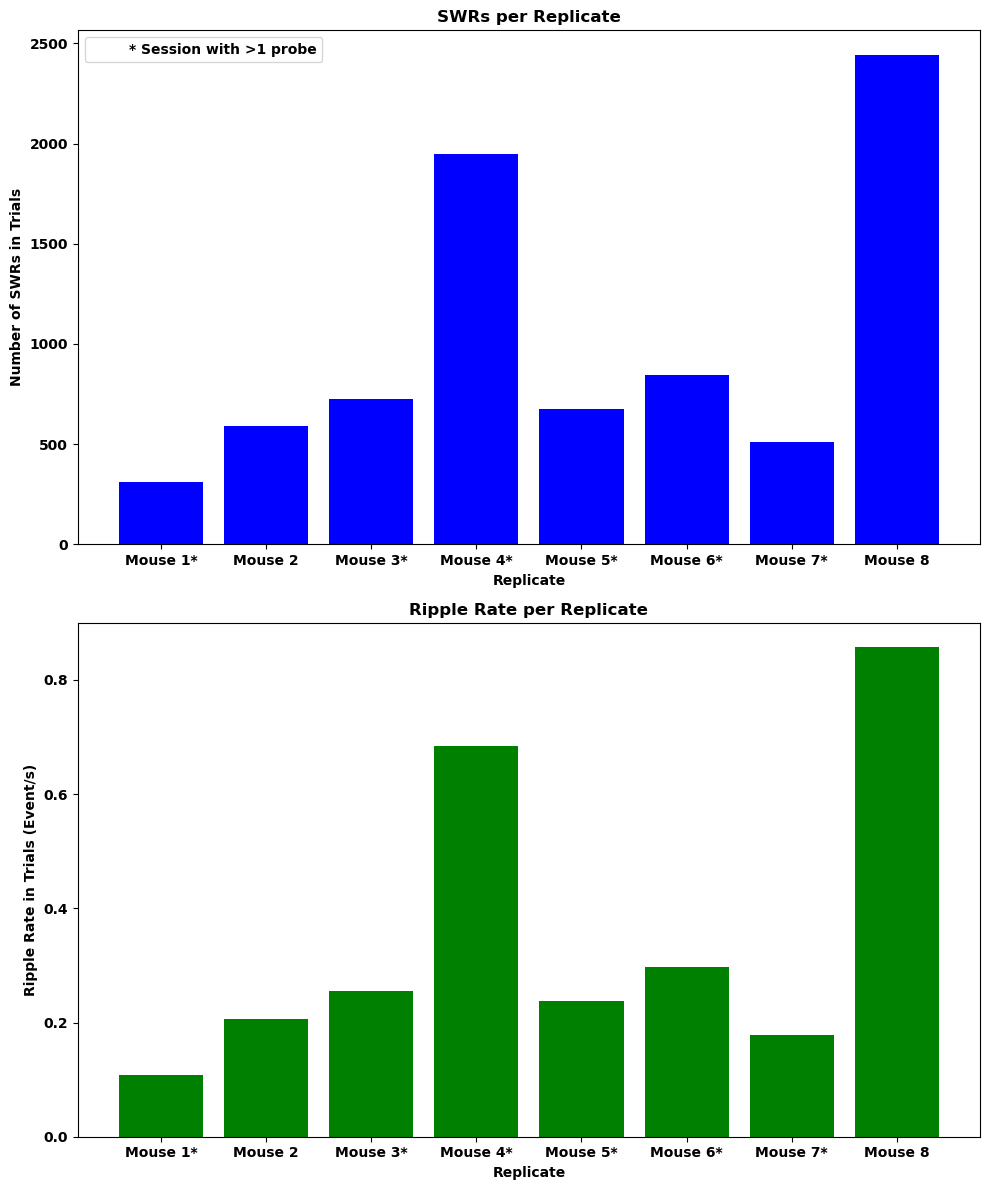

In [111]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Create the first bar plot
axs[0].bar(range(len(total_swrs.index)), total_swrs['swrs_in_trial'].values, color='blue')

# Set the x-ticks to the numbered labels
axs[0].set_xticks(range(len(total_swrs.index)))
axs[0].set_xticklabels(labels)

# Set the title and labels
axs[0].set_title('SWRs per Replicate', fontweight='bold')
axs[0].set_xlabel('Replicate', fontweight='bold')
axs[0].set_ylabel('Number of SWRs in Trials', fontweight='bold')

# Create a Patch for the legend
star_patch = mpatches.Patch(color='none', label='* Session with >1 probe')

# Add the legend to the plot
axs[0].legend(handles=[star_patch])

# Create the second bar plot
axs[1].bar(range(len(total_swrs.index)), total_swrs['ripple_rate'].values, color='green')

# Set the x-ticks to the numbered labels
axs[1].set_xticks(range(len(total_swrs.index)))
axs[1].set_xticklabels(labels)

# Set the title and labels
axs[1].set_title('Ripple Rate per Replicate', fontweight='bold')
axs[1].set_xlabel('Replicate', fontweight='bold')
axs[1].set_ylabel('Ripple Rate in Trials (Event/s)', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

Here we can also see the distribution of ripple events per trial in each mouse.

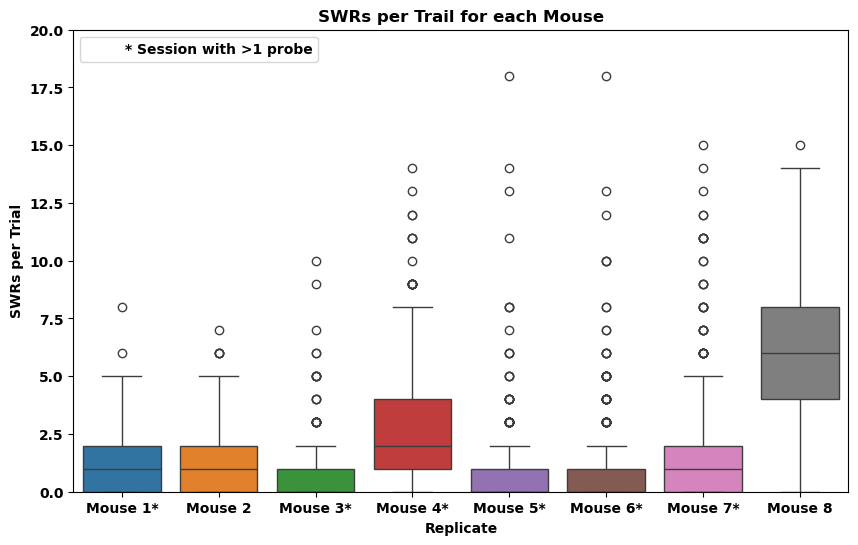

In [112]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Set all fonts to be bold
mpl.rcParams['font.weight'] = 'bold'

# Initialize an empty DataFrame to store 'swrs_in_trial' for each replicate
data = pd.DataFrame()

# Loop over each replicate
for rep in contrast_df.replicate_num.unique():
    # Select the 'swrs_in_trial' column for the current replicate
    swrs_in_trial = contrast_df[contrast_df.replicate_num==rep]['swrs_in_trial']
    
    # Append the results to the DataFrame
    data = pd.concat([data, swrs_in_trial.rename(rep)], axis=1)

# Create a box plot of the distribution of 'swrs_in_trial' for each replicate
plt.figure(figsize=(10, 6))
sns.boxplot(data=data)
star_patch = mpatches.Patch(color='none', label='* Session with >1 probe')

# Add the legend to the plot
plt.legend(handles=[star_patch])

# Set the x-ticks to the numbered labels
plt.xticks(range(len(total_swrs.index)), labels)

# Set the y-axis limit
plt.ylim(0, 20)

# Set the title and labels
plt.title('SWRs per Trail for each Mouse', fontweight='bold')
plt.xlabel('Replicate', fontweight='bold')
plt.ylabel('SWRs per Trial', fontweight='bold')

# Show the plot
plt.show()

Now we want to see which task events the SWRs are most correlated to.  In literature uncertainty and reward seem to be driving factors of SWRs.  I suspect the task difficulty, defined as the weakness or strength of the stimuli may drive ripples and that the reward should also drive ripples.  It may be different for each mouse as well so we can compute Pearson correlations and compute the significance of the correlation per mouse, as this is multiple comparisons I will correct with the BH method at an FDR of 0.05.

/tmp/ipykernel_57206/227849775.py:91: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  boxplot.set_xticklabels(labels)


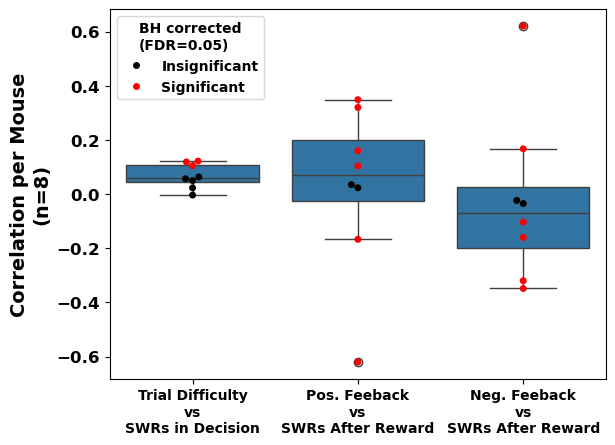

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests

fdrthresh = 0.05

# Get the unique replicate numbers
replicates = contrast_df['replicate_num'].unique()

# Initialize an empty DataFrame to store the results
results_df1 = pd.DataFrame(columns=['replicate', 'correlation', 'p_value', 'effect'])

# Loop over each replicate
for i in replicates:
    # Subset the data for the current replicate
    subset = contrast_df[contrast_df['replicate_num'] == i]
    
    # Calculate the correlation
    correlation, p_value = stats.pearsonr((1-abs(subset['contrast_diff'])), subset['swrs_in_decision'])
    
    # Append the results to the DataFrame
    results_df1 = results_df1.append({'replicate': i, 'correlation': correlation, 'p_value': p_value, 'effect': 'contrast_diff'}, ignore_index=True)

# Correct for multiple comparisons using the Benjamini-Hochberg method
reject, pvals_corrected, _, _ = multipletests(results_df1['p_value'], method='fdr_bh')
results_df1['p_value_corrected'] = pvals_corrected
results_df1['significant'] = reject

# Initialize an empty DataFrame to store the results
results_df2 = pd.DataFrame(columns=['replicate', 'correlation', 'p_value', 'effect'])

# Loop over each replicate
for i in replicates:
    # Subset the data for the current replicate
    subset = contrast_df[contrast_df['replicate_num'] == i]
    
    # Calculate the correlation
    correlation, p_value = stats.pearsonr(subset['feedbackType'] == -1, subset['swrs_after_reward'])
    
    # Append the results to the DataFrame
    results_df2 = results_df2.append({'replicate': i, 'correlation': correlation, 'p_value': p_value, 'effect': 'feedbackType_-1'}, ignore_index=True)

# Correct for multiple comparisons using the Benjamini-Hochberg method
reject, pvals_corrected, _, _ = multipletests(results_df2['p_value'], method='fdr_bh')
results_df2['p_value_corrected'] = pvals_corrected
results_df2['significant'] = reject

# Initialize an empty DataFrame to store the results
results_df3 = pd.DataFrame(columns=['replicate', 'correlation', 'p_value', 'effect'])

# Loop over each replicate
for i in replicates:
    # Subset the data for the current replicate
    subset = contrast_df[contrast_df['replicate_num'] == i]
    
    # Calculate the correlation
    correlation, p_value = stats.pearsonr(subset['feedbackType'] == 1, subset['swrs_after_reward'])
    
    # Append the results to the DataFrame
    results_df3 = results_df3.append({'replicate': i, 'correlation': correlation, 'p_value': p_value, 'effect': 'feedbackType_1'}, ignore_index=True)

# Correct for multiple comparisons using the Benjamini-Hochberg method
reject, pvals_corrected, _, _ = multipletests(results_df3['p_value'], method='fdr_bh', alpha=fdrthresh,)
results_df3['p_value_corrected'] = pvals_corrected
results_df3['significant'] = reject

# Concatenate the dataframes
results_df = pd.concat([results_df1, results_df2, results_df3])


# Concatenate the dataframes
results_df = pd.concat([results_df1, results_df2, results_df3])

# Create a boxplot for each effect
boxplot = sns.boxplot(x='effect', y='correlation', data=results_df)

# Add the swarmplot, coloring the dots based on significance
swarmplot = sns.swarmplot(x='effect', y='correlation', data=results_df, hue='significant', palette={True: 'red', False: 'black'})
# Get the current handles and labels
handles, labels = swarmplot.get_legend_handles_labels()
# Change 'True' and 'False' to 'Significant' and 'Insignificant'
labels = ['Significant' if label == 'True' else 'Insignificant' for label in labels]

# Set a new legend with the desired title
swarmplot.legend(handles, labels, title=f'BH corrected\n(FDR={fdrthresh})')

# Set the x-tick labels
labels = ['Trial Difficulty\nvs\nSWRs in Decision', 'Pos. Feeback\nvs\nSWRs After Reward', 'Neg. Feeback\nvs\nSWRs After Reward']
boxplot.set_xticklabels(labels)

# Set the y axis label
plt.xlabel('')
plt.ylabel('Correlation per Mouse\n(n=8)', fontsize=14, weight='bold')

# Set the font size of the tick labels
plt.xticks(fontsize=10, weight='bold')
plt.yticks(fontsize=12, weight='bold')
plt.show()

It appears that the SWRs are at best weakly correlated to task difficulty and only in some mice.  Intriguingly some mice also apprear to favor a negative feedback, or the absence of reward compared to the water reward.  This could be due to probe placement picking up different sections of hippocampus or individual strategies.  Further investigation is required.

## Timing of SWRs in response to task data

When the SWRs occur informs us of what they are being driven by and responding to.  Here we can graph how they align with respect to various aspects of the data.  This can be used to show concrete examples of what the above correlations imply.

In [114]:
test_list = prior_switching_processed_ids
#test_list = ['5339812f-8b91-40ba-9d8f-a559563cc46b']
for i, session_id in enumerate(test_list, start=1):
    print(session_id)
    # Load the trials for the current session
    d = one.load_object(session_id, 'trials', collection='alf')

    # Process the trials to create a DataFrame
    trials_df = process_dict(d)

111c1762-7908-47e0-9f40-2f2ee55b6505
83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4
09b2c4d1-058d-4c84-9fd4-97530f85baf6
1a507308-c63a-4e02-8f32-3239a07dc578
8a3a0197-b40a-449f-be55-c00b23253bbf
0c828385-6dd6-4842-a702-c5075f5f5e81
5339812f-8b91-40ba-9d8f-a559563cc46b
931a70ae-90ee-448e-bedb-9d41f3eda647


In [115]:
import pandas as pd

test_list = prior_switching_processed_ids
#test_list = ['5339812f-8b91-40ba-9d8f-a559563cc46b']

# Initialize an empty list to store each trials_df
trials_df_list = []
swrs_df_list = []
df_list = []

for i, session_id in enumerate(test_list, start=1):
    print(session_id)
    # Load the trials for the current session
    d = one.load_object(session_id, 'trials', collection='alf')

    # Process the trials to create a DataFrame
    trials_df = process_dict(d)
    
    # Add a new column 'session_id' filled with the current session_id
    trials_df['session_id'] = session_id

    # Append the dataframe to the list
    df_list.append(trials_df)
    
    session_dir = os.path.join(swrs_input_dir, f"swrs_session_{session_id}")

    # Get all csv files in the directory
    csv_files = glob.glob(os.path.join(session_dir, '*.csv'))

    # Concatenate all csv files into a single DataFrame and reset the index
    unfiltered_events_df = pd.concat((pd.read_csv(file, index_col=0).reset_index(drop=True) for file in csv_files))

    # Filter the DataFrame based on the 'Overlaps_with_movement' column
    filtered_df = unfiltered_events_df[unfiltered_events_df['Overlaps_with_movement'] == False]

    # Sort the DataFrame based on the 'start_time' column
    filtered_df = filtered_df.sort_values('start_time')

    # Merge rows where the start time difference is less than or equal to 0.015s, keeping the row with the largest 'max_zscore'
    merged_swr_df = pd.DataFrame()
    i = 0
    while i < len(filtered_df) - 1:
        if filtered_df.iloc[i+1]['start_time'] - filtered_df.iloc[i]['start_time'] <= 0.015:
            # Get the row with the largest 'max_zscore'
            max_zscore_row = filtered_df.iloc[i:i+2].loc[filtered_df.iloc[i:i+2]['max_zscore'].idxmax()]
            
            # Update 'start_time', 'end_time', and 'duration'
            max_zscore_row['start_time'] = min(filtered_df.iloc[i]['start_time'], filtered_df.iloc[i+1]['start_time'])
            max_zscore_row['end_time'] = max(filtered_df.iloc[i]['end_time'], filtered_df.iloc[i+1]['end_time'])
            max_zscore_row['duration'] = max_zscore_row['end_time'] - max_zscore_row['start_time']
            
            merged_swr_df = merged_swr_df.append(max_zscore_row)
            i += 2
        else:
            merged_swr_df = merged_swr_df.append(filtered_df.iloc[i])
            i += 1

    merged_swr_df = merged_swr_df[merged_swr_df.max_zscore>swr_thresh]
    merged_swr_df['session_id'] = session_id
    swrs_df_list.append(merged_swr_df)

# Concatenate all the dataframes in the list into one big dataframe
all_trials_df = pd.concat(df_list)
all_swrs_df = pd.concat(swrs_df_list)

111c1762-7908-47e0-9f40-2f2ee55b6505


83e77b4b-dfa0-4af9-968b-7ea0c7a0c7e4
09b2c4d1-058d-4c84-9fd4-97530f85baf6
1a507308-c63a-4e02-8f32-3239a07dc578
8a3a0197-b40a-449f-be55-c00b23253bbf
0c828385-6dd6-4842-a702-c5075f5f5e81
5339812f-8b91-40ba-9d8f-a559563cc46b
931a70ae-90ee-448e-bedb-9d41f3eda647


In [116]:
all_swrs_df.head()

,event_number,start_time,end_time,duration,mean_zscore,median_zscore,max_zscore,min_zscore,speed_at_start,speed_at_end,max_speed,min_speed,median_speed,mean_speed,Peak_Amp_RipBandPower,Peak_Amp_RipBandPower_zscore,Peak_time,Overlaps_with_gamma,Overlaps_with_movement,session_id
0,1,0.173273,0.322606,0.149333,1.224287,0.654962,4.717016,0.008476,0.0,0.0,0.0,0.0,0.0,0.0,7.853920e-09,2.292188,0.296606,False,False,111c1762-7908-47e0-9f40-2f2ee55b6505
1,2,0.674606,0.833940,0.159333,1.680223,1.733912,4.328187,0.006463,0.0,0.0,0.0,0.0,0.0,0.0,7.322025e-09,2.128544,0.723273,False,False,111c1762-7908-47e0-9f40-2f2ee55b6505
2,3,1.019273,1.128606,0.109333,1.874853,1.792299,4.425350,0.051238,0.0,0.0,0.0,0.0,0.0,0.0,8.138572e-09,2.379765,1.033273,False,False,111c1762-7908-47e0-9f40-2f2ee55b6505
3,4,1.348606,1.532606,0.184000,1.393622,1.303774,3.411621,0.027515,0.0,0.0,0.0,0.0,0.0,0.0,5.755857e-09,1.646692,1.464606,False,False,111c1762-7908-47e0-9f40-2f2ee55b6505
4,5,2.148607,2.289940,0.141333,1.253269,1.094670,3.793756,0.001836,0.0,0.0,0.0,0.0,0.0,0.0,5.135728e-09,1.455902,2.259273,False,False,111c1762-7908-47e0-9f40-2f2ee55b6505


In [117]:
all_trials_df.head()

,goCueTrigger_times,stimOff_times,feedback_times,contrastRight,feedbackType,response_times,goCue_times,contrastLeft,probabilityLeft,choice,firstMovement_times,stimOn_times,rewardVolume,intervals_start,intervals_end,session_id
0,64.234163,65.850359,64.789689,NaN,1.0,64.789574,64.235072,1.00,0.5,1.0,64.594966,64.234006,1.5,63.711253,66.350407,111c1762-7908-47e0-9f40-2f2ee55b6505
1,68.816249,73.817170,72.766432,0.125,1.0,72.766318,68.817090,NaN,0.5,-1.0,71.423966,68.816090,1.5,66.734312,74.317247,111c1762-7908-47e0-9f40-2f2ee55b6505
2,75.232761,76.616982,75.566177,NaN,1.0,75.566067,75.233441,0.25,0.5,1.0,75.439966,75.232574,1.5,74.736353,77.117095,111c1762-7908-47e0-9f40-2f2ee55b6505
3,78.583118,80.266251,79.193915,1.000,1.0,79.193829,78.583770,NaN,0.5,-1.0,79.033966,78.582937,1.5,77.529399,80.766360,111c1762-7908-47e0-9f40-2f2ee55b6505
4,82.350581,84.483768,83.413199,NaN,1.0,83.413096,82.351429,0.00,0.5,1.0,82.750966,82.350362,1.5,81.206966,84.983820,111c1762-7908-47e0-9f40-2f2ee55b6505


In [118]:
def filter_swr_by_event(events_df, swr_df, event_col_of_interest, time_offset):
    """
    Returns a 1D array of times aligned to the event.

    Parameters:
    events_df (pandas.DataFrame): The dataframe containing the event data.
    swr_df (pandas.DataFrame): The dataframe containing the SWR data.
    event_col_of_interest (str): The name of the column containing the event values.
    time_offset (float): The range in seconds for filtering the times.

    Returns:
    numpy.ndarray: A 1D array of times aligned to the event.
    """
    aligned_times = []

    # Loop over each unique session
    for session_id in events_df['session_id'].unique():
        # Create a mask for the current session
        session_mask = swr_df['session_id'] == session_id

        # Get the event times for the current session
        session_event_times = events_df[events_df['session_id'] == session_id][event_col_of_interest]

        # Loop over each event time
        for event_time in session_event_times:
            # Create a mask for the times within the offset of the event time
            time_mask = np.abs(swr_df['Peak_time'] - event_time) <= time_offset

            # Combine the session mask and the time mask
            combined_mask = session_mask & time_mask

            # Filter the swr_df using the combined mask and append the times to the list
            aligned_times.extend(swr_df[combined_mask]['Peak_time'] - event_time)

    # Convert the list to a 1D numpy array
    aligned_times = np.array(aligned_times)

    return aligned_times

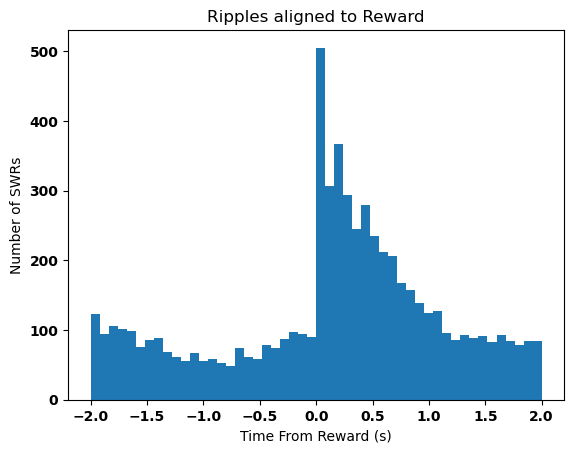

In [119]:
offsetval = 2

reward_times = filter_swr_by_event(all_trials_df[all_trials_df.feedbackType>0], all_swrs_df,
                    event_col_of_interest='feedback_times',
                    time_offset=offsetval)

plt.hist(reward_times, bins=50)
plt.xlabel('Time From Reward (s)')
plt.ylabel('Number of SWRs')
plt.title('Ripples aligned to Reward')
plt.show()

The sum of events seems to indicate that following reward there is a spread of events happening.  In order to illustrate what this looks like at the single trial level lets find an example trail such as a trial on the sessionw e've been plotting with the highest number of post reward SWRs then plot the LFP.

In [120]:
session_id = '1a507308-c63a-4e02-8f32-3239a07dc578'

d = one.load_object(session_id, 'trials', collection='alf')

# Process the trials to create a DataFrame
trials_df = process_dict(d)
trials_df.head()

,stimOff_times,goCueTrigger_times,feedback_times,contrastLeft,firstMovement_times,contrastRight,response_times,goCue_times,choice,feedbackType,probabilityLeft,rewardVolume,stimOn_times,intervals_start,intervals_end
0,32.834283,31.499928,31.730327,1.00,31.413099,NaN,31.730230,31.500816,1.0,1.0,0.5,1.5,31.499783,28.302303,33.334346
1,39.150485,37.616395,38.034296,NaN,37.777099,0.125,38.034200,37.617105,-1.0,1.0,0.5,1.5,37.616271,33.856547,39.650523
2,44.450321,43.115862,43.340765,0.25,43.101099,NaN,43.340664,43.116755,1.0,1.0,0.5,1.5,43.115721,42.437656,44.950382
3,47.633370,46.065791,46.506082,NaN,46.220099,1.000,46.505997,46.066726,-1.0,1.0,0.5,1.5,46.065593,45.493284,48.133421
4,54.898510,49.298833,53.788354,0.00,49.421099,NaN,53.788278,49.299703,1.0,1.0,0.5,1.5,49.298636,48.721027,55.398596


In [140]:
thistrial_contrast_df = contrast_df[contrast_df.replicate_num==session_id].reset_index(drop=True)
thistrial_contrast_df.head()

,original_trial_number,current_trial,contrast_diff,contrast_diff_minmax,n_trial_back_1,n_trial_back_2,prior,prior_contrastdiff,session_avg,session_avg_3_20,...,feedbackType,swrs_in_trial_minmax,swrs_in_decision_minmax,swrs_after_reward_minmax,time_from_last_swr_to_decision_minmax,swrs_after_reward_lasttrial_minmax,swr_prior_minmax,swr_prior_contrastdiff_minmax,swrs_in_decision_y_or_n,replicate_num
0,50,1,-0.0625,0.46875,1.0,1.0,0.553191,-0.005319,0.568627,0.65,...,1.0,0.193548,0.0,0.384615,0.033809,0.538462,0.0,0.0,False,931a70ae-90ee-448e-bedb-9d41f3eda647
1,51,1,-0.2500,0.37500,1.0,1.0,0.541667,0.000000,0.576923,0.65,...,1.0,0.258065,0.0,0.538462,0.034792,0.461538,0.0,0.0,False,931a70ae-90ee-448e-bedb-9d41f3eda647
2,52,1,-0.1250,0.43750,1.0,1.0,0.551020,-0.005102,0.584906,0.65,...,1.0,0.193548,0.0,0.461538,0.029189,0.538462,0.0,0.0,False,931a70ae-90ee-448e-bedb-9d41f3eda647
3,53,0,0.1250,0.56250,1.0,1.0,0.560000,-0.025000,0.574074,0.65,...,1.0,0.225806,0.0,0.538462,0.026506,0.692308,0.0,0.0,False,931a70ae-90ee-448e-bedb-9d41f3eda647
4,54,0,0.0625,0.53125,0.0,1.0,0.568627,-0.025735,0.563636,0.60,...,1.0,0.290323,0.0,0.692308,0.041650,0.153846,0.0,0.0,False,931a70ae-90ee-448e-bedb-9d41f3eda647


In [141]:
thistrial_contrast_df.original_trial_number[thistrial_contrast_df.swrs_after_reward.argmax()]

84

Now that we have the trial number we can plot the lfp trace, I will mark the SWRs with faded red in this plot.

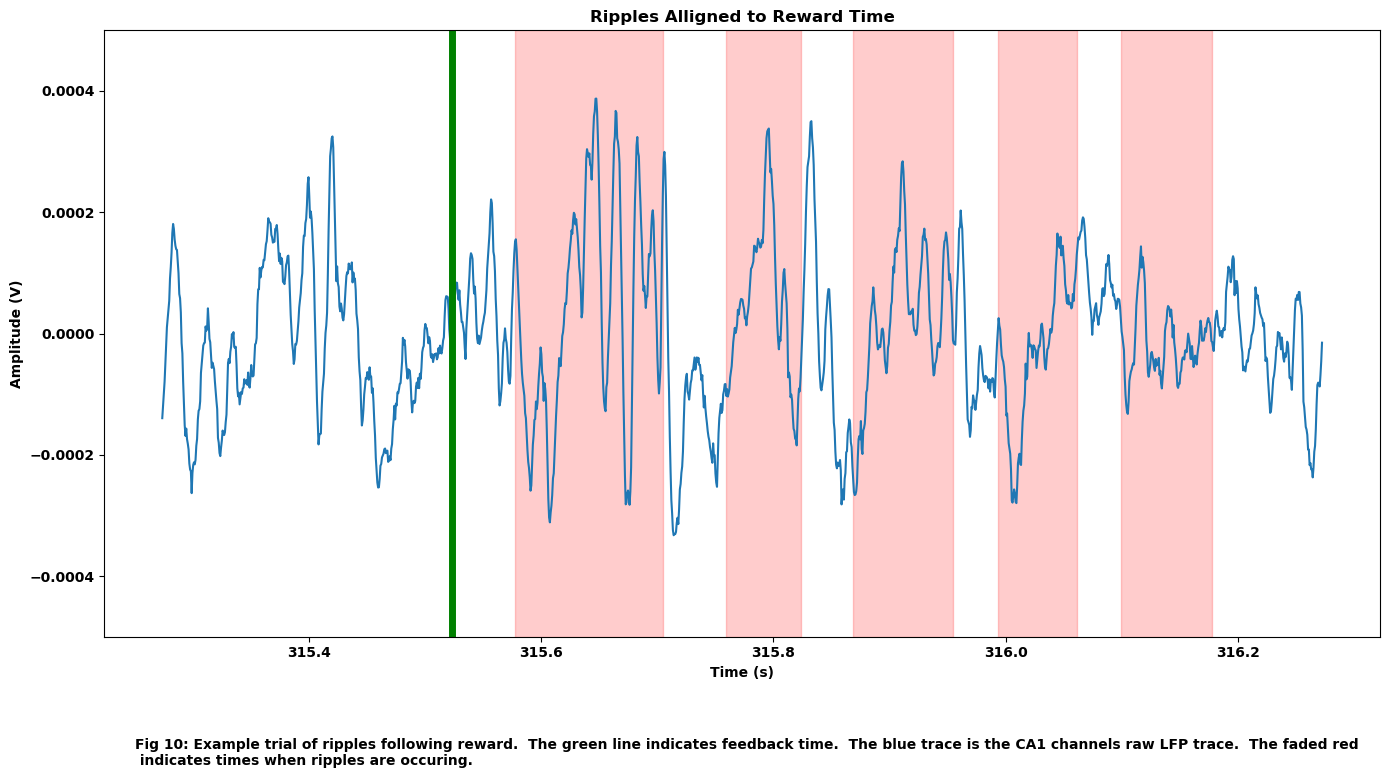

In [168]:
## CHANGE THIS VARIABLE TO THE RIPPLE ID YOU WANT TO PLOT, EXPLORE THE DATA A BIT TO FIND A GOOD RIPPLE
trial_id = 84

all_swrs_df[all_swrs_df.session_id == session_id]

rewardtime = trials_df.feedback_times[trial_id]
mask = (time_arr > (rewardtime-0.25)) & (time_arr < (rewardtime+0.75))
time_arr_slice = time_arr[mask]
ca1_channel_lfp_slice = ca1_channel_lfp[mask]
ca1_ripple_power_slice = ripple_band_ca1[mask]

# Create a figure
plt.figure(figsize=(14, 7))

# Plot the CA1 LFP signal
plt.plot(time_arr_slice, ca1_channel_lfp_slice)
plt.ylim(-0.0005, 0.0005)


# Get the events for the current session
session_events = all_swrs_df[all_swrs_df.session_id == session_id]

# Get all the events that occur within the time window of the reward time
events_in_window = session_events[(session_events.start_time >= (rewardtime-0.25)) & (session_events.end_time <= (rewardtime+0.75))]

# Loop over all the events and shade the sections with ripples
for _, event in events_in_window.iterrows():
    plt.axvspan(event.start_time, event.end_time, color='r', alpha=0.2)  # Shade the section with a ripple

# Add a solid green line for the reward time
plt.axvline(x=rewardtime, color='g', linewidth=5)

# Set the title and labels
plt.title('Ripples Alligned to Reward Time', fontweight='bold')
plt.xlabel('Time (s)', fontweight='bold')
plt.ylabel('Amplitude (V)', fontweight='bold')

# Add a figure legend (block of text) beneath the figure
plt.figtext(0.1, -0.1, "Fig 10: Example trial of ripples following reward.  The green line indicates feedback time.  The blue trace is the CA1 channels raw LFP trace.  The faded red \n indicates times when ripples are occuring. ", ha="left")

plt.tight_layout()
plt.show()

We can likewise look at ripple rates during hard decisions.

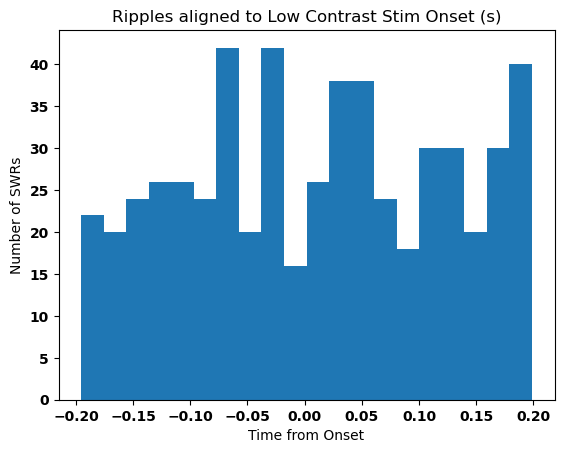

In [ ]:
offsetval = 0.2
hard_trial_idx = (all_trials_df.contrastLeft < 0.25) | (all_trials_df.contrastRight < 0.25)


reward_times = filter_swr_by_event(all_trials_df[hard_trial_idx], all_swrs_df,
                    event_col_of_interest='stimOn_times',
                    time_offset=offsetval)

plt.hist(reward_times, bins=20)
plt.xlabel('Time from Onset')
plt.ylabel('Number of SWRs')
plt.title('Ripples aligned to Low Contrast Stim Onset (s)')
plt.show()

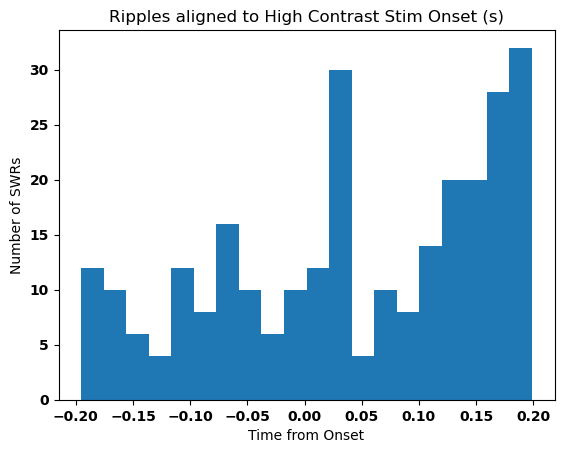

In [ ]:
offsetval = 0.2
hard_trial_idx = (all_trials_df.contrastLeft > 0.25) | (all_trials_df.contrastRight > 0.25)


reward_times = filter_swr_by_event(all_trials_df[hard_trial_idx], all_swrs_df,
                    event_col_of_interest='stimOn_times',
                    time_offset=offsetval)

plt.hist(reward_times, bins=20)
plt.xlabel('Time from Onset')
plt.ylabel('Number of SWRs')
plt.title('Ripples aligned to High Contrast Stim Onset (s)')
plt.show()

In [ ]:
np.correlate(reward_times[0:10], offset_vector[0:10], mode='full')

array([ -4.99601299,  -9.99202597, -14.98047171, -19.96891744,
       -24.93327521, -29.89763297, -34.8230809 , -39.74852883,
       -44.66910676, -49.58968468, -44.59367169, -39.59765871,
       -34.60921297, -29.62076724, -24.65640947, -19.69205171,
       -14.76660378,  -9.84115585,  -4.92057792])

## References

Cheng, S., & Frank, L. M. (2008). New experiences enhance coordinated neural activity in the hippocampus. Neuron, 57(2), 303-313.

De Filippo, R., & Schmitz, D. (2023). Differential ripple propagation along the hippocampal longitudinal axis. Elife, 12, e85488.

Liu, A. A., Henin, S., Abbaspoor, S., Bragin, A., Buffalo, E. A., Farrell, J. S., ... & Buzsáki, G. (2022). A consensus statement on detection of hippocampal sharp wave ripples and differentiation from other fast oscillations. Nature communications, 13(1), 6000.

Jeong, H., Namboodiri, V. M. K., Jung, M. W., & Andermann, M. L. (2023). Sensory cortical ensembles exhibit differential coupling to ripples in distinct hippocampal subregions. Current Biology, 33(23), 5185-5198.

Nitzan, N., Swanson, R., Schmitz, D., & Buzsáki, G. (2022). Brain-wide interactions during hippocampal sharp wave ripples. Proceedings of the National Academy of Sciences, 119(20), e2200931119.